In [86]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Введение

В этой работе нами будут рассмотрены методы машинного обучения в задачах ценобразования на рынке недвижимости.

Будет представлено решение задачи регрессии - предсказание цены на квартиру в Москве в зависимости от её параметров.

## Загрузка данных

В качестве данных в нашей работе будет выступать датасет с предложениями квартир в Москве за ноябрь 2020 года. *Источник: [kaggle.com](https://www.kaggle.com/datasets/alexeyleshchenko/moscow-apartment-listings).*

Выборка ограничена расстоянием объекта от центра города (рассматриваются только объекты, находящиеся на расстоянии не более, чем 25 км от центра), одно- и двухкомнатными квартирами и предложениями с ценой от 4 до 20 миллионов рублей.

In [2]:
import pandas as pd

# Загрузка данных
file_path = 'moscow_apartment_listings.csv'
data = pd.read_csv(file_path, delimiter=',')

## Описательный анализ и предобработка данных

### Описательный анализ

Рассмотрим датасет:

In [3]:
data.head()

,price,repair,year_built_empty,house_age,closest_subway,dist_to_subway,sg,lat,lon,subway_dist_to_center,...,subway_offers,address_offers,rooms,footage,floor,max_floor,first_floor,last_floor,AO,hm
0,8000000,3,0,42,59,960,0.0,55.609009,37.734632,17166,...,5,1.0,1,39.4,11,12,0,0,UAO,panel
1,7200000,2,0,43,59,802,0.0,55.608760,37.741936,17166,...,9,1.0,1,35.6,2,9,0,0,UAO,panel
2,10300000,2,0,43,59,638,0.0,55.610207,37.742495,17166,...,9,2.0,2,53.0,5,12,0,0,UAO,panel
3,8500000,2,0,43,59,929,0.0,55.624017,37.740373,17166,...,5,1.0,2,44.1,8,9,0,0,UAO,panel
4,9000000,2,0,43,59,785,0.0,55.609107,37.740430,17166,...,5,1.0,2,44.2,6,9,0,0,UAO,panel


Изучим подробнее признаки:

1. `price` - Цена квартиры в российских рублях.
2. `repair` - Cостояние квартиры, представлено как целое число от 1 до 4, от худшего к лучшему.
3. `year_built_empty` - "1" если мы знаем год постройки дома, иначе "0".
4. `house_age` - Возраст дома.
5. `closest_subway` - Идентификатор ближайшей станции метро.
6. `dist_to_subway` - Расстояние до ближайшей станции метро в метрах.
7. `sg` - Вид метро: "0" - Подземный, "1" - Московское центральное колько (МЦК) "2" - Московский центральный диаметр (МЦД) "3" - Монорельc.
8. `lat` - Широта.
9. `lon` - Долгота.
10. `subway_dist_to_center` - Расстояние от ближайщей к объекту станции метро до центра города в метрах.
11. `h3` - Координата в системе геопространственного индексирования Uber.
12. `agent_offers` - Количество объявлений от этого агента.
13. `subway_offers` - Количество объявлений в непосредственной близости от этой станции метро.
14. `address_offers` - Количество объявлений по одному и тому же адресу.
15. `rooms` - Количество комнат.
16. `footage` - Общая площадь в квадратных метрах.
17. `floor` - Этаж.
18. `max_floor` - Этажность здания.
19. `first_floor` - "1", если квартира находится на первом этаже.
20. `last_floor` - "1", если квартира находится на последнем этаже.
21. `AO` - Административный округ.
22. `hm` - Материал стен.

В нашем датасете есть несколько признаков, отвечающих за расположение объекта в городе.\
Это:
1. `AO`
2. `lat`
3. `lon`
4. `closest_subway`
5. `subway_dist_to_center`
6. `h3`

Признак `h3`, связанный с расположением объекта в системе геопространственного индексирования, можно вычислить на основе координат широты и долготы объекта. К тому же, он трудно интерпретируемый и не является числовым, поэтому его можно удалить из данных.

In [4]:
data.drop(["h3"], axis=1, inplace=True)

Дальнейшие действия с остальными признаками, обозначающими расположение, можно будет узнать только просле описательного анализа.

Проверим датасет на наличие либо отсутствие пропущенных значений и на тип признаков:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12181 entries, 0 to 12180
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  12181 non-null  int64  
 1   repair                 12181 non-null  int64  
 2   year_built_empty       12181 non-null  int64  
 3   house_age              12181 non-null  int64  
 4   closest_subway         12181 non-null  int64  
 5   dist_to_subway         12181 non-null  int64  
 6   sg                     12181 non-null  float64
 7   lat                    12181 non-null  float64
 8   lon                    12181 non-null  float64
 9   subway_dist_to_center  12181 non-null  int64  
 10  agent_offers           12181 non-null  int64  
 11  subway_offers          12181 non-null  int64  
 12  address_offers         12181 non-null  float64
 13  rooms                  12181 non-null  int64  
 14  footage                12181 non-null  float64
 15  fl

Видим, что нет пропущенных значений, но есть категориальные признаки: нечисловые - `AO` и `hm` и числовые - `closest_subway`. Приведем их к соответствующему типу:

In [6]:
cat_feat = ['closest_subway', 'AO', 'hm']
for features in cat_feat:
    data[features] = data[features].astype('category')
data.dtypes

price                       int64
repair                      int64
year_built_empty            int64
house_age                   int64
closest_subway           category
dist_to_subway              int64
sg                        float64
lat                       float64
lon                       float64
subway_dist_to_center       int64
agent_offers                int64
subway_offers               int64
address_offers            float64
rooms                       int64
footage                   float64
floor                       int64
max_floor                   int64
first_floor                 int64
last_floor                  int64
AO                       category
hm                       category
dtype: object

Узнаем размер датасета:

In [7]:
print(f'Размер данных (кол-во строк и столбцов): {data.shape}')

Размер данных (кол-во строк и столбцов): (12181, 21)


### Исследуем признаки.

#### 1. 
Так как уже при сборе данных признаки `price`, `rooms` и `subway_dist_to_center` были ограничены, их проверять не нужно.\
Визуализируем распределение значений этих признаков:

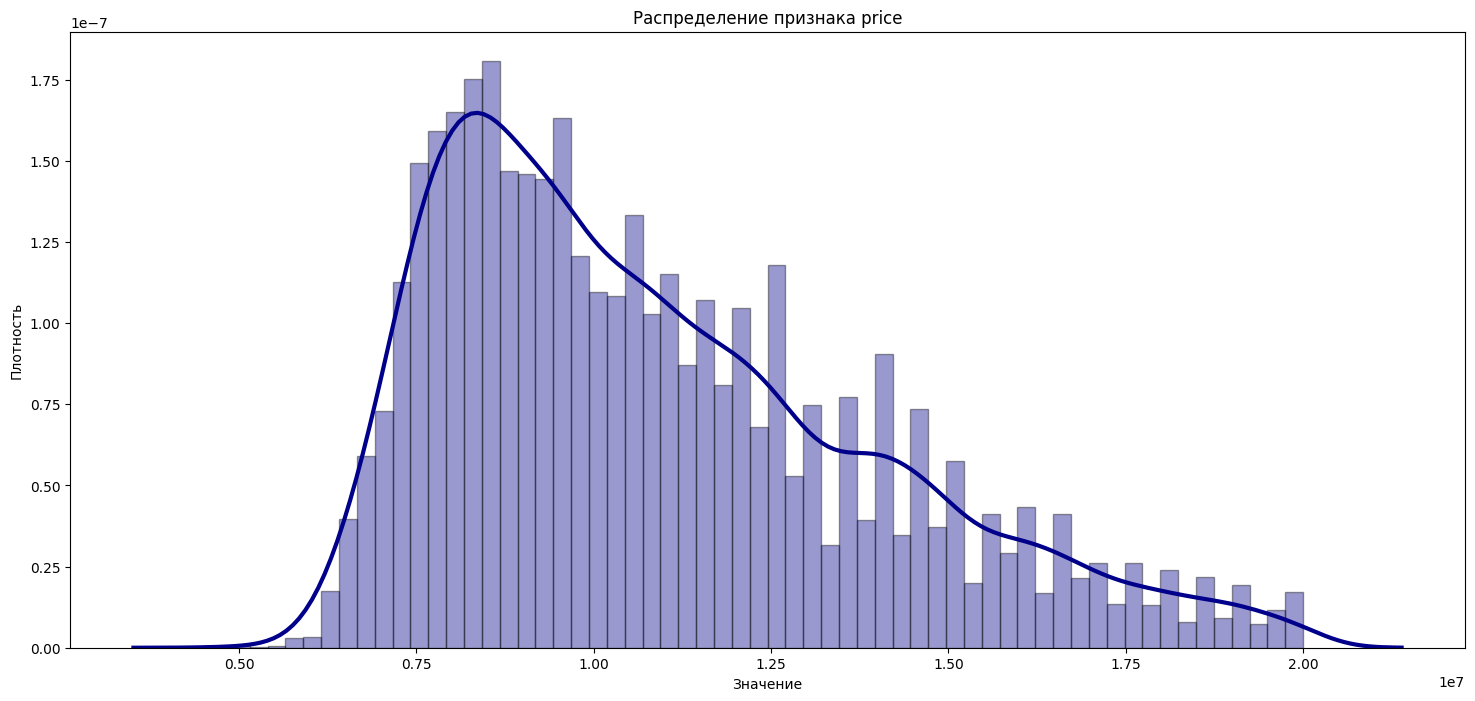

In [8]:
plt.figure(figsize=(18, 8))
ax = sns.distplot(data['price'], hist=True, kde=True, 
             bins=60, color='darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})
ax.set(xlabel="Значение", ylabel="Плотность", title="Распределение признака price")
plt.show()

Для наглядности распределения цены квартиры в зависимости от ее расположения наложим на схему административных округов Москвы точки, обозначающие квартиры. При этом чем больше размер точки, тем больше цена квартиры.

Для этой процедуры использован shapefile c картой Москвы с разделением на округа и районы - [kaggle.com](https://www.kaggle.com/datasets/jtremoureux/administrative-divisions-of-moscow?select=moscow_adm.shp).

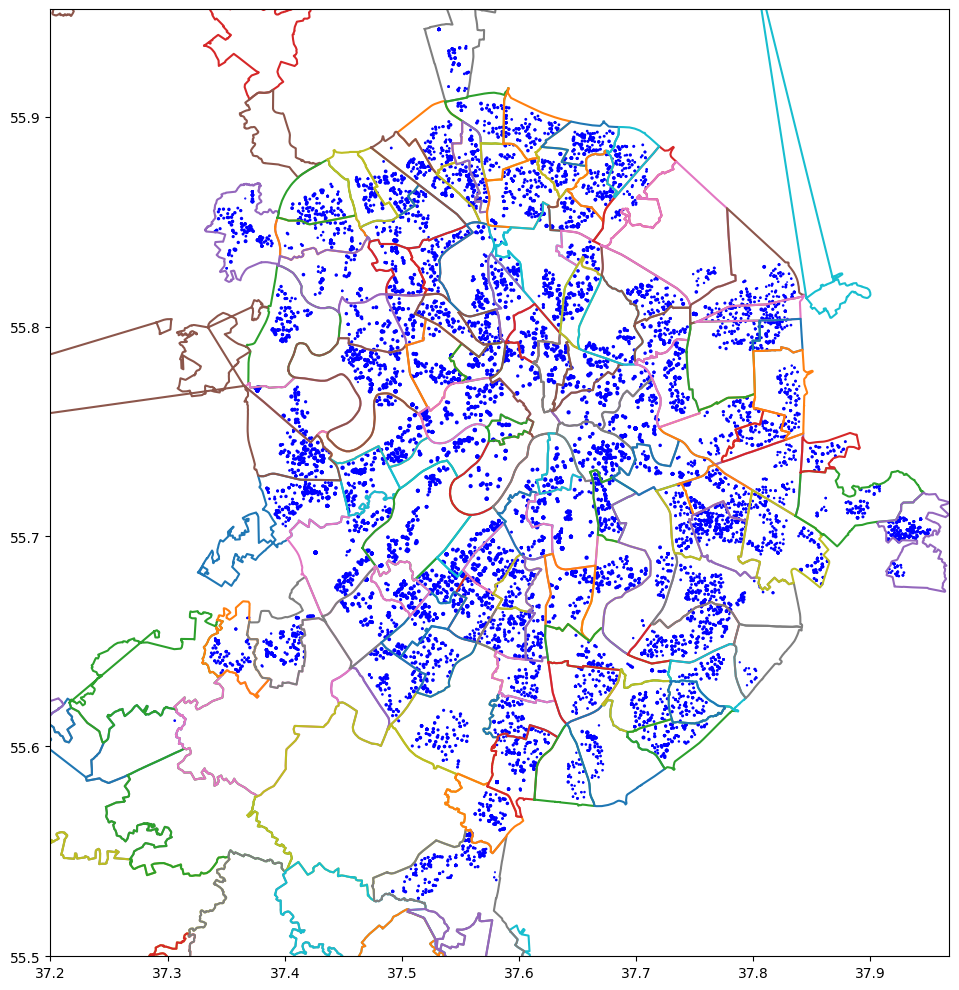

In [9]:
# Для соответствия размера точек величине цены масштабируем значения цены
price = data['price'].values

from sklearn.preprocessing import minmax_scale

scale_price = minmax_scale(price, feature_range=(0.05, 5))

import shapefile as shp

sf = shp.Reader("moscow_adm.shp")
X, Y = [], []
plt.figure(figsize=(11.6, 12.3))
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    X.append(x)
    Y.append(y)
    plt.plot(x,y)
    
lat = data[['lat']].values
lon = data[['lon']].values

plt.scatter(lon, lat, s=scale_price, color='b')
plt.xlim(37.2, max(sum(X, [])))
plt.ylim(55.50, max(sum(Y, []))-0.07)
plt.show()

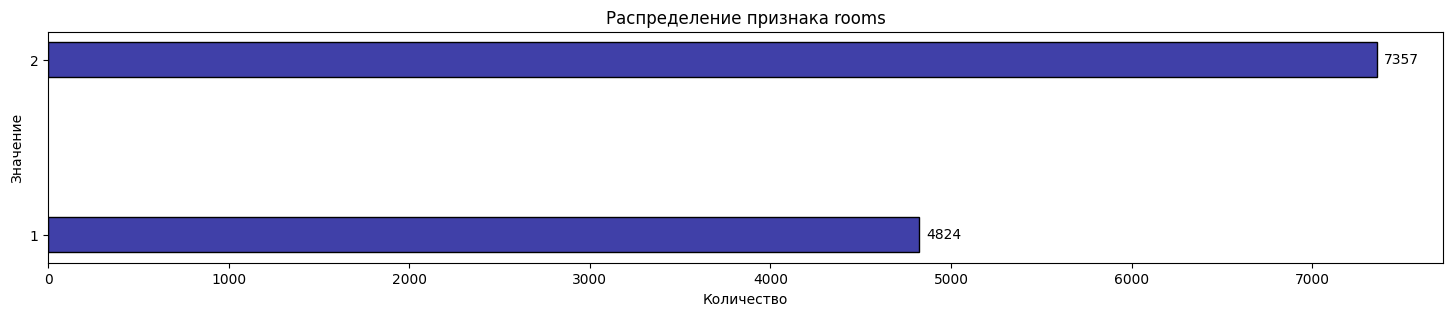

In [10]:
plt.figure(figsize=(18, 3))
ax = sns.histplot(data=data, y="rooms", bins=2, shrink=0.2, discrete=True, color='darkblue')
ax.set_yticks([1, 2])
ax.set(xlabel="Количество", ylabel="Значение", title="Распределение признака rooms")
ax.bar_label(ax.containers[0], fmt='%.0f', padding=5)
plt.show()

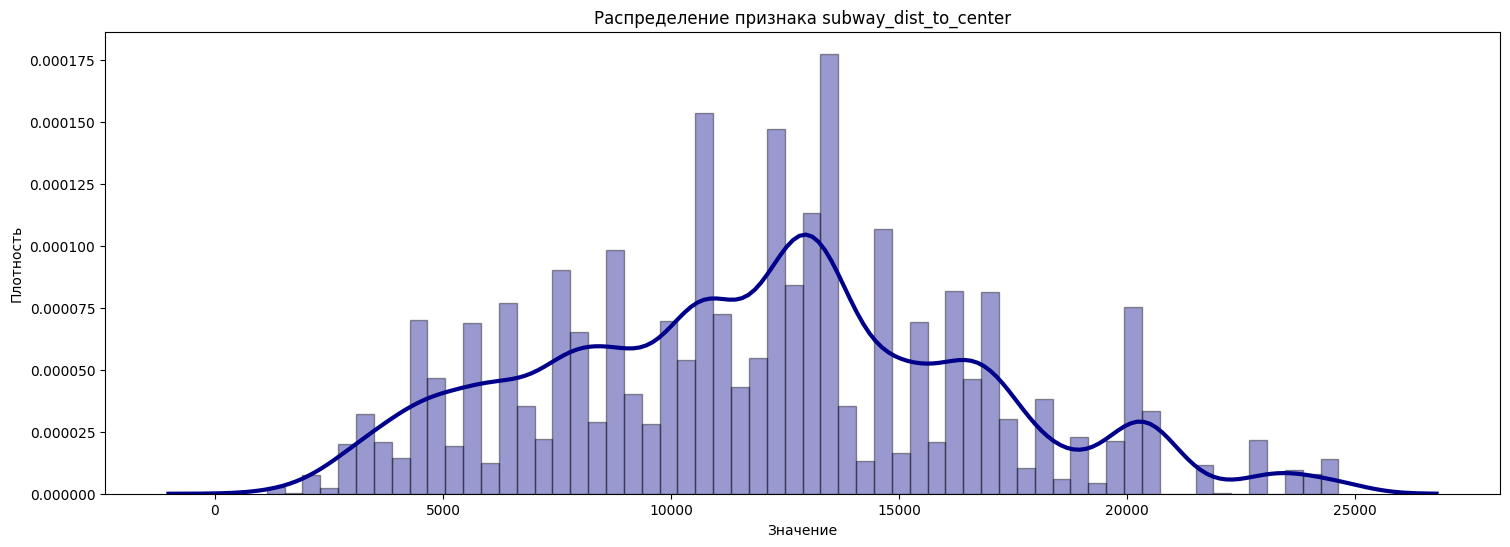

In [11]:
plt.figure(figsize=(18, 6))
ax = sns.distplot(data['subway_dist_to_center'], hist=True, kde=True, 
             bins=60, color='darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})
ax.set(xlabel="Значение", ylabel="Плотность", title="Распределение признака subway_dist_to_center")
plt.show()

Никаких аномалий распределения этих признаков не обнаружено.

#### 2.
Проверим распределение признака `repair`:

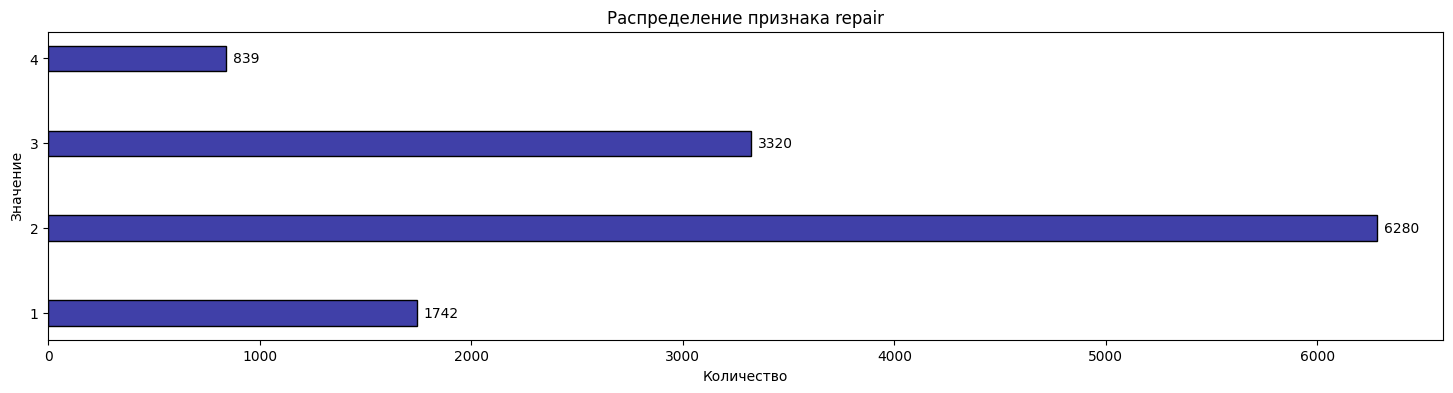

In [12]:
plt.figure(figsize=(18, 4))
ax = sns.histplot(data=data, y="repair", bins=4, shrink=0.3, discrete=True, color='darkblue')
ax.set_yticks([1, 2, 3, 4])
ax.set(xlabel="Количество", ylabel="Значение", title="Распределение признака repair")
ax.bar_label(ax.containers[0], fmt='%.0f', padding=5)
plt.show()

Все значения принадлежат нужному интервалу и валидны.

#### 3.
Далее рассмотрим признаки, связанные с годом постройки: `year_built_empty` и `house_age`. Визуализируем их распределения:

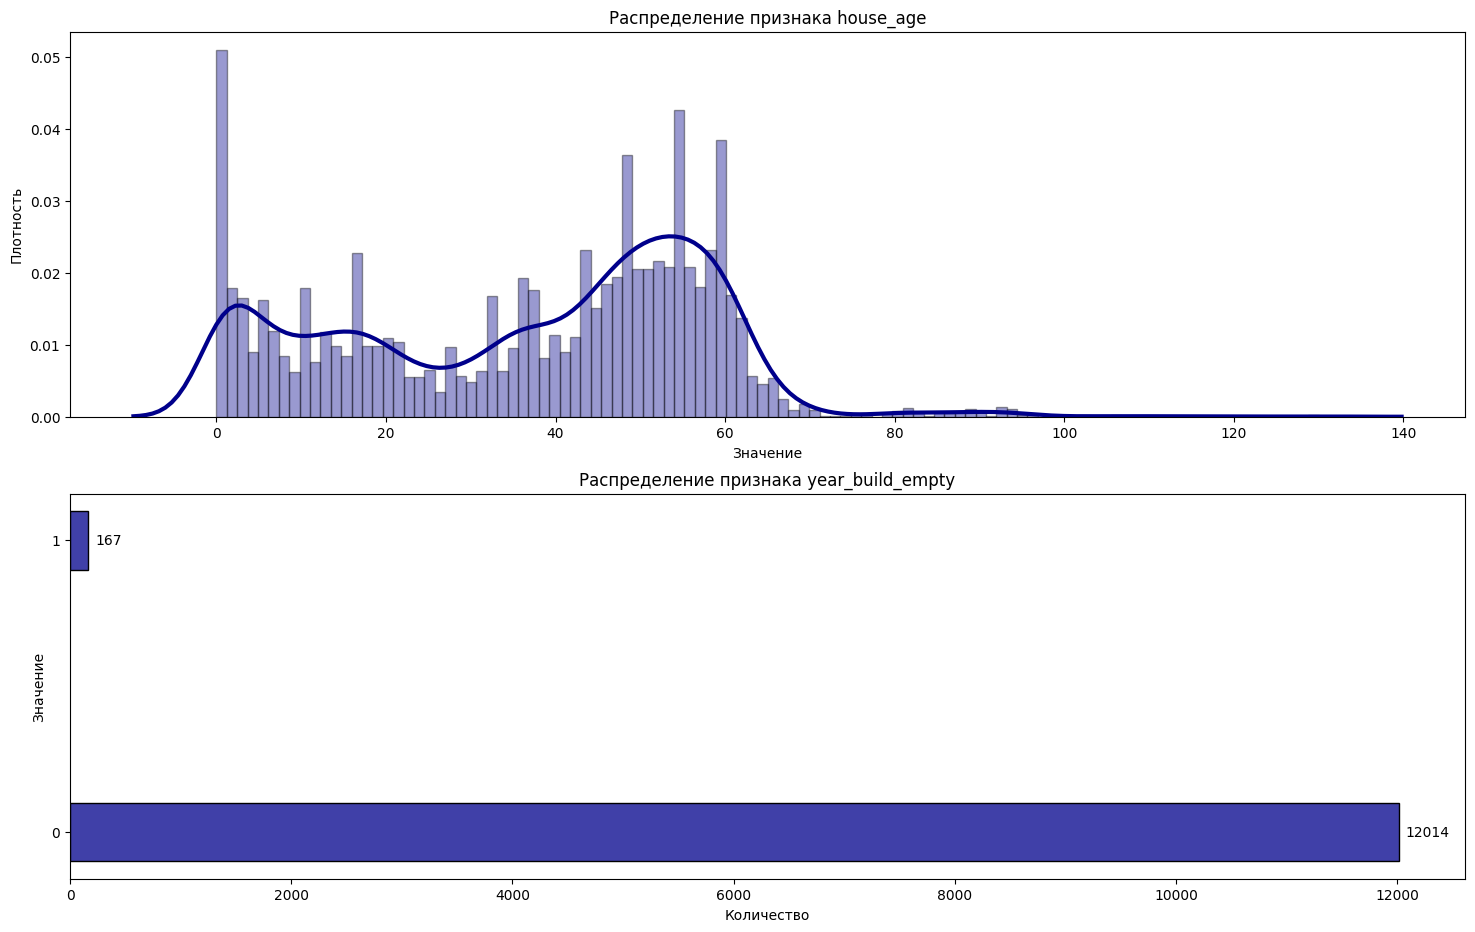

In [13]:
fig, axes = plt.subplots(2, 1)
fig.set_figheight(11)
fig.set_figwidth(18)

sns.distplot(data['house_age'], hist=True, kde=True, 
             bins=len(np.unique(data[['house_age']])), color='darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3}, ax=axes[0])
axes[0].set(xlabel="Значение", ylabel="Плотность", title="Распределение признака house_age")

sns.histplot(data=data, y="year_built_empty", bins=2, shrink=0.2, discrete=True, color='darkblue', ax=axes[1])
axes[1].set_yticks([0, 1])
axes[1].set(xlabel="Количество", ylabel="Значение", title="Распределение признака year_build_empty")
axes[1].bar_label(axes[1].containers[0], fmt='%.0f', padding=5)

plt.show()

Признак `year_built_empty` не информативен - он не показывает, знаем ли мы год постройки дома или нет, так как у признака `house_age` нет пропущенных значений, a `year_built_empty` принимает оба возможныз значения, `0` и `1`.\
Его можно удалить из датасета, так как он нерелевантный.

In [14]:
data.drop(["year_built_empty"], axis=1, inplace=True)

#### 4.
Теперь рассмотрим признаки, связанные с этажами: `floor`, `max_floor`, `first_floor` и `last_floor`.

Для начала, проверим данные на достоверность:
1. Признаки `first_floor` и `last_floor` принимают только значения `0` и `1`.
2. Для каждой квартиры выполняется условие: `floor` <= `max_floor`.

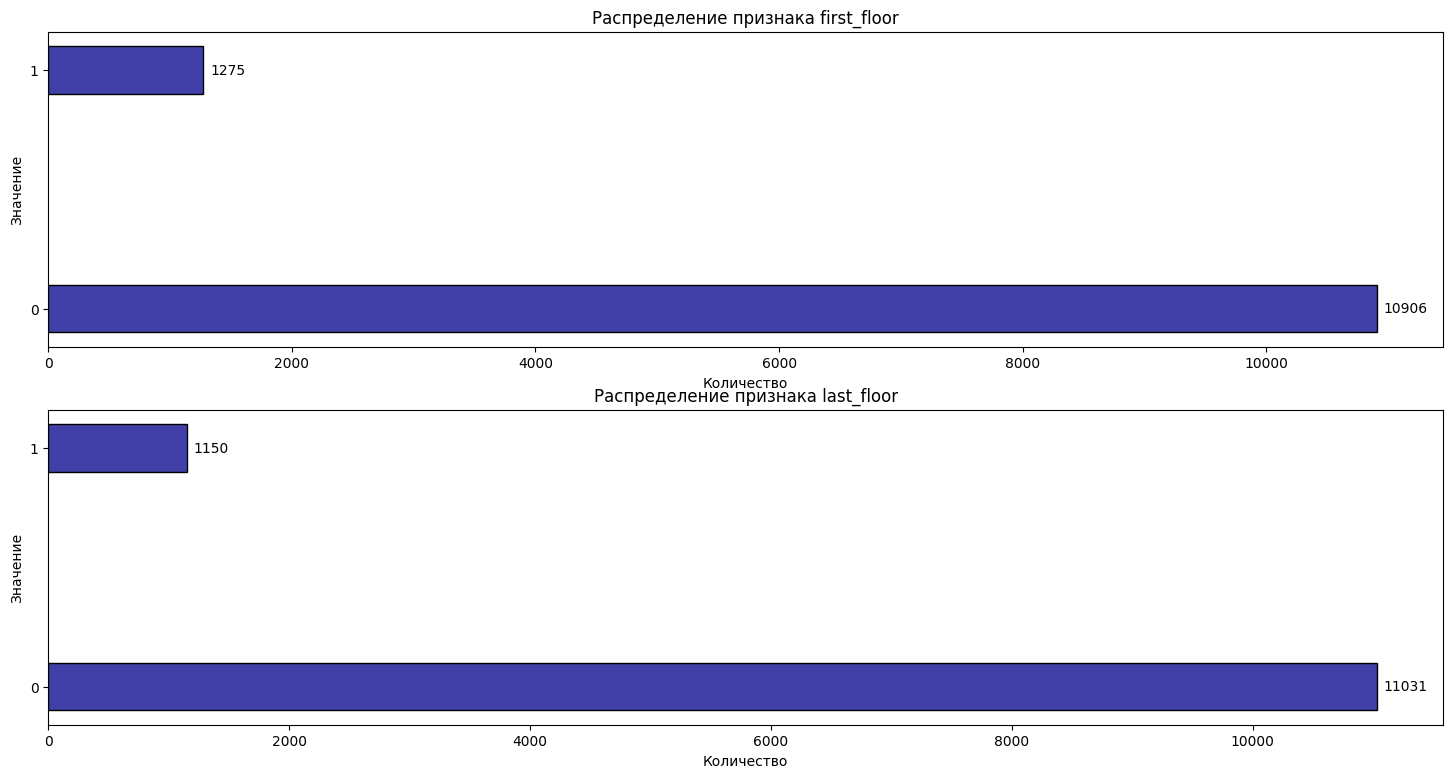

In [15]:
fig, axes = plt.subplots(2, 1)
fig.set_figheight(9)
fig.set_figwidth(18)

sns.histplot(data=data, y="first_floor", bins=2, shrink=0.2, discrete=True, color='darkblue', ax=axes[0])
axes[0].set_yticks([0, 1])
axes[0].set(xlabel="Количество", ylabel="Значение", title="Распределение признака first_floor")
axes[0].bar_label(axes[0].containers[0], fmt='%.0f', padding=5)

sns.histplot(data=data, y="last_floor", bins=2, shrink=0.2, discrete=True, color='darkblue', ax=axes[1])
axes[1].set_yticks([0, 1])
axes[1].set(xlabel="Количество", ylabel="Значение", title="Распределение признака last_floor")
axes[1].bar_label(axes[1].containers[0], fmt='%.0f', padding=5)

plt.show()

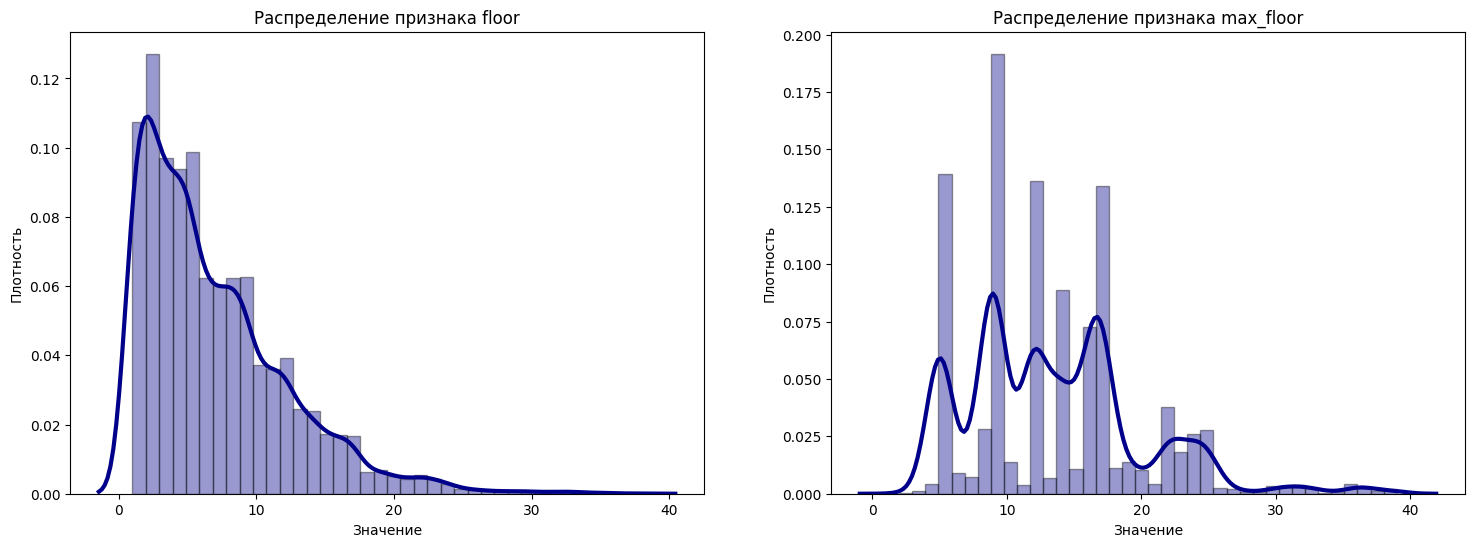

In [16]:
fig, axes = plt.subplots(1, 2)
fig.set_figheight(6)
fig.set_figwidth(18)

sns.distplot(data['floor'], hist=True, kde=True, 
             bins=len(np.unique(data[['floor']])), color='darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3}, ax=axes[0])
axes[0].set(xlabel="Значение", ylabel="Плотность", title="Распределение признака floor")

sns.distplot(data['max_floor'], hist=True, kde=True, 
             bins=len(np.unique(data[['max_floor']])), color='darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3}, ax=axes[1])
axes[1].set(xlabel="Значение", ylabel="Плотность", title="Распределение признака max_floor")

plt.show()

In [17]:
# Условия, которые ддолжны выполняться для признаков floor, max_floor, first_floor, last_floor:
# cond1 - все значения признака floor для каждой квартиры не больше значения признака max_floor
# cond2 - количество значений "1" признака last_floor равняются количеству квартир, расположенных на последнем этаже
# cond3 - количество значений "1" признака first_floor равняются количеству квартир, расположенных на первом этаже 

cond1 = np.all(
    data[['max_floor']].values >= data[['floor']].values)
cond2 = np.count_nonzero(
    data[['last_floor']]) == np.count_nonzero(data[data['floor'] == data['max_floor']]['floor'])
cond3 = np.count_nonzero(
    data[['first_floor']]) == np.count_nonzero(data[data['floor'] == 1]['floor'])

if all((cond1, cond2, cond3)):
    print(f'Все условия для признаков floor, max_floor, first_floor, last_floor выполняются')
else:
    print(f'Не все условия для признаков floor, max_floor, first_floor, last_floor выполняются')

Все условия для признаков floor, max_floor, first_floor, last_floor выполняются


Добавим в датасет признак `floor_ratio`, показывающий отношение номера этажа, на котором находится квартира, к количеству этажей в доме:

In [18]:
data['floor_ratio'] = data['floor'] / data['max_floor']

Визуализируем его распределение:

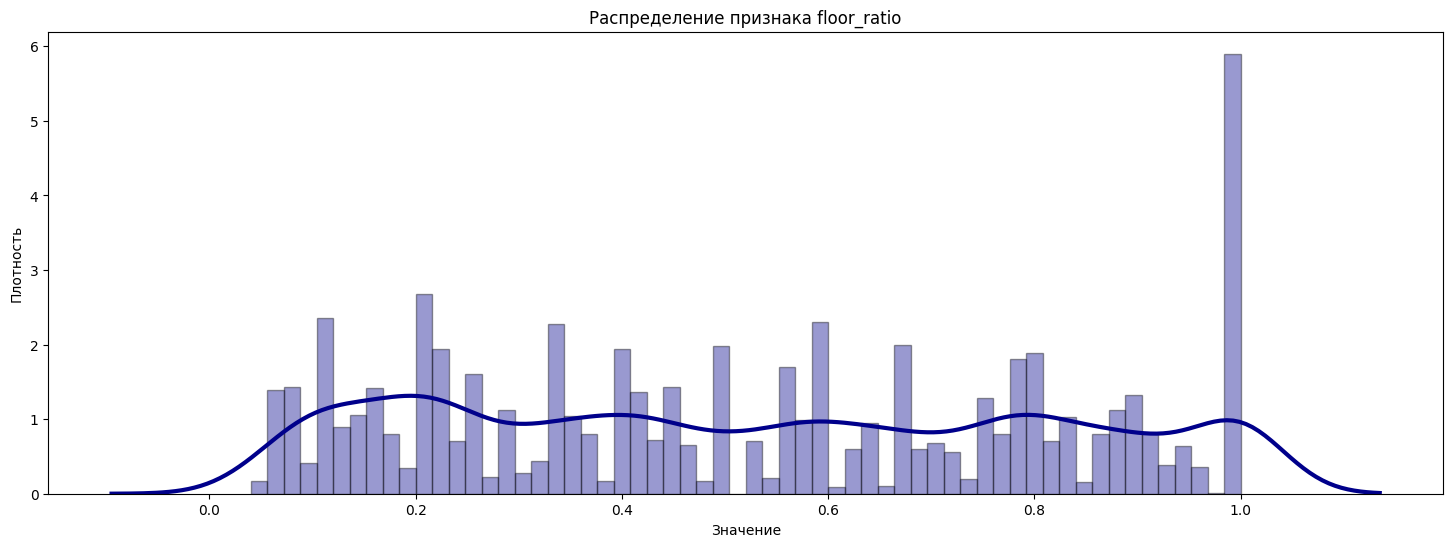

In [19]:
plt.figure(figsize=(18, 6))
ax = sns.distplot(data['floor_ratio'], hist=True, kde=True, 
             bins=60, color='darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})
ax.set(xlabel="Значение", ylabel="Плотность", title="Распределение признака floor_ratio")
plt.show()

#### 5.
Рассмотрим распределение территориальных признаков:

`sg` - признак, показывающего вид ближайшей к кваритире станции метро: "0" - Подземный, "1" - Московское центральное колько (МЦК) "2" - Московский центральный диаметр (МЦД) "3" - Монорельc.

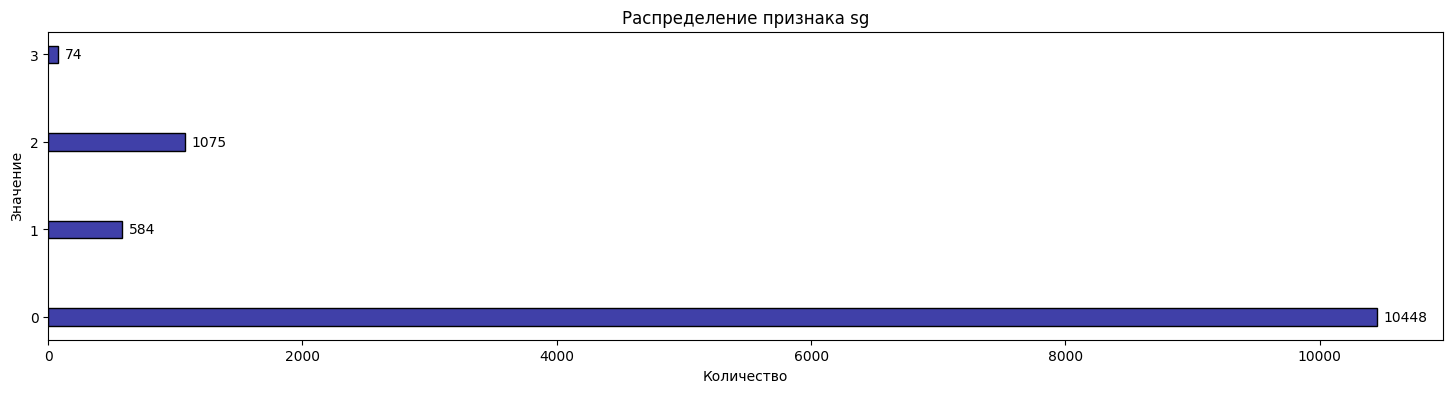

In [20]:
plt.figure(figsize=(18, 4))
ax = sns.histplot(data=data, y="sg", bins=2, shrink=0.2, discrete=True, color='darkblue')
ax.set_yticks([0, 1, 2, 3])
ax.set(xlabel="Количество", ylabel="Значение", title="Распределение признака sg")
ax.bar_label(ax.containers[0], fmt='%.0f', padding=5)
plt.show()

Значение признака `closest_subway` показывает идентификатор ближайшей станции метро:

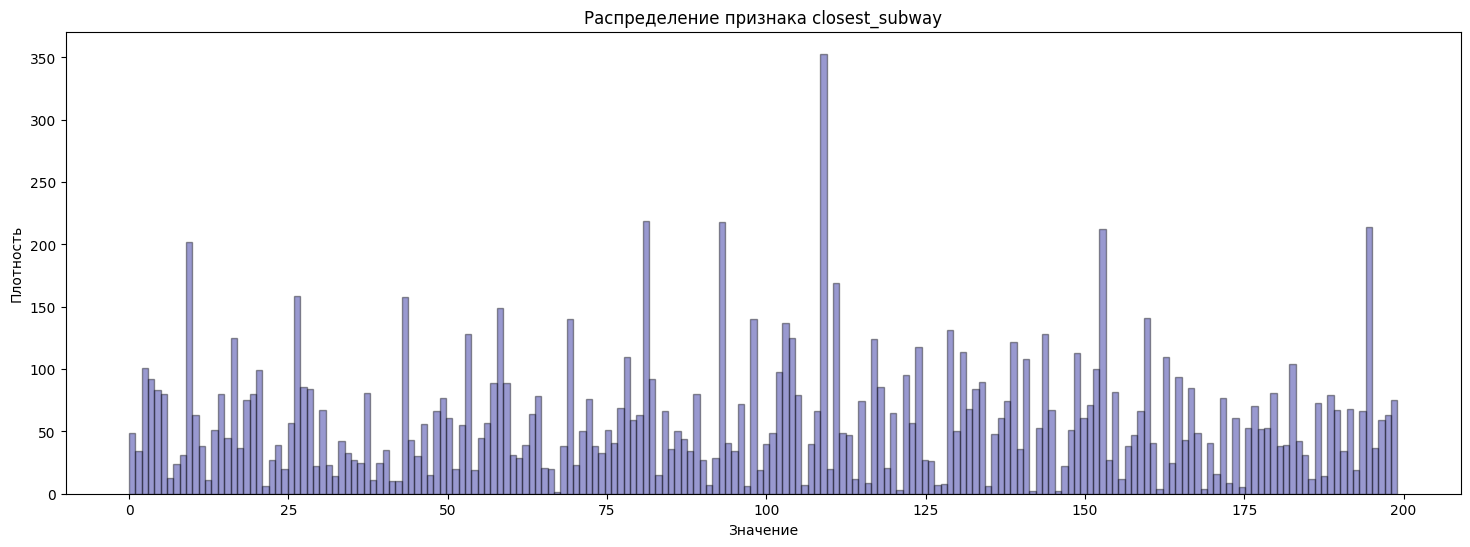

In [21]:
plt.figure(figsize=(18, 6))
ax = sns.distplot(data['closest_subway'], hist=True, kde=False, 
             bins=len(np.unique(data[['closest_subway']])), color='darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})
ax.set(xlabel="Значение", ylabel="Плотность", title="Распределение признака closest_subway")
plt.show()

На момент сбора данных Москва была поделена на 12 админстративных округов. Проверим значения признака `AO`:

In [22]:
print(f'Значения признака AO: {np.unique(data[["AO"]])}')
print(f"Количество уникальных значений признака АО: {len(np.unique(data[['AO']]))}")

Значения признака AO: ['CAO' 'SAO' 'SVAO' 'SZAO' 'UAO' 'UVAO' 'UZAO' 'VAO' 'ZAO']
Количество уникальных значений признака АО: 9


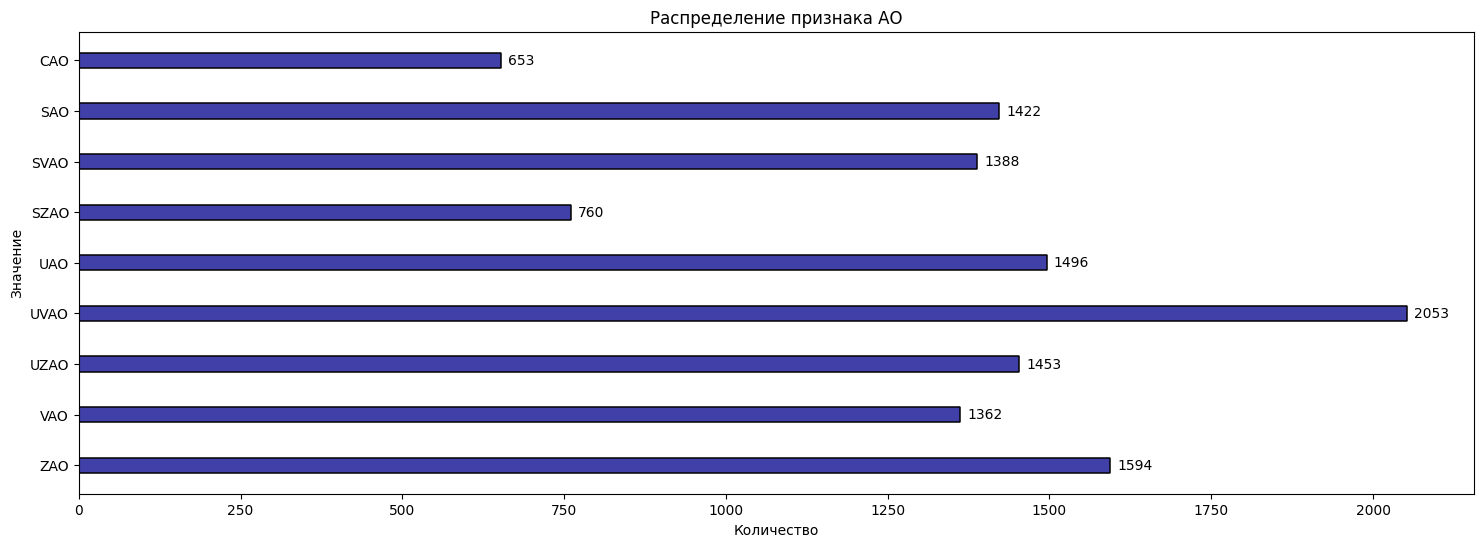

In [23]:
plt.figure(figsize=(18, 6))
ax = sns.histplot(data=data, y="AO", bins=9, shrink=0.3, discrete=True, color='darkblue')
ax.set_yticks(np.unique(data[["AO"]]))
ax.set(xlabel="Количество", ylabel="Значение", title="Распределение признака АО")
ax.bar_label(ax.containers[0], fmt='%.0f', padding=5)
plt.show()

В выборке представлены только 9 из 12 административных округов. Тем не менее, все значения валидны.

Признак `dist_to_subway` показывает расстояние до ближайшей станции метро.

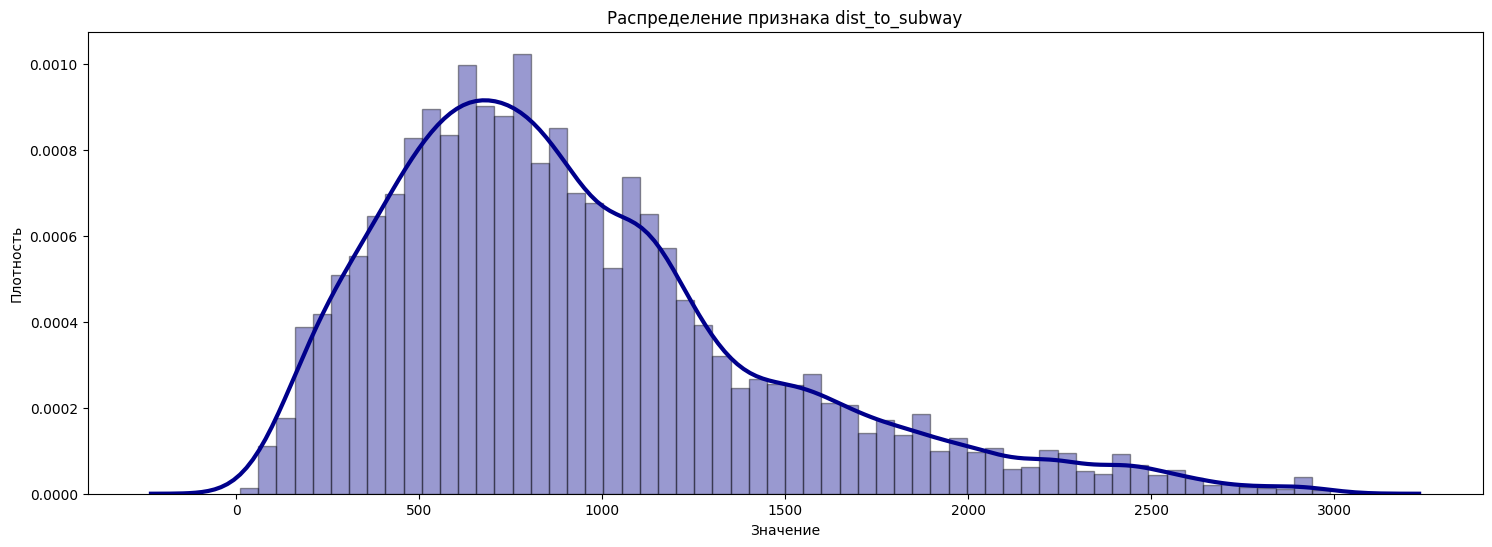

In [24]:
plt.figure(figsize=(18, 6))
ax = sns.distplot(data['dist_to_subway'], hist=True, kde=True, 
             bins=60, color='darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})
ax.set(xlabel="Значение", ylabel="Плотность", title="Распределение признака dist_to_subway")
plt.show()

Параметры `lat` и `lon` показывают географические координаты объекта (широту и долготу соответственно).

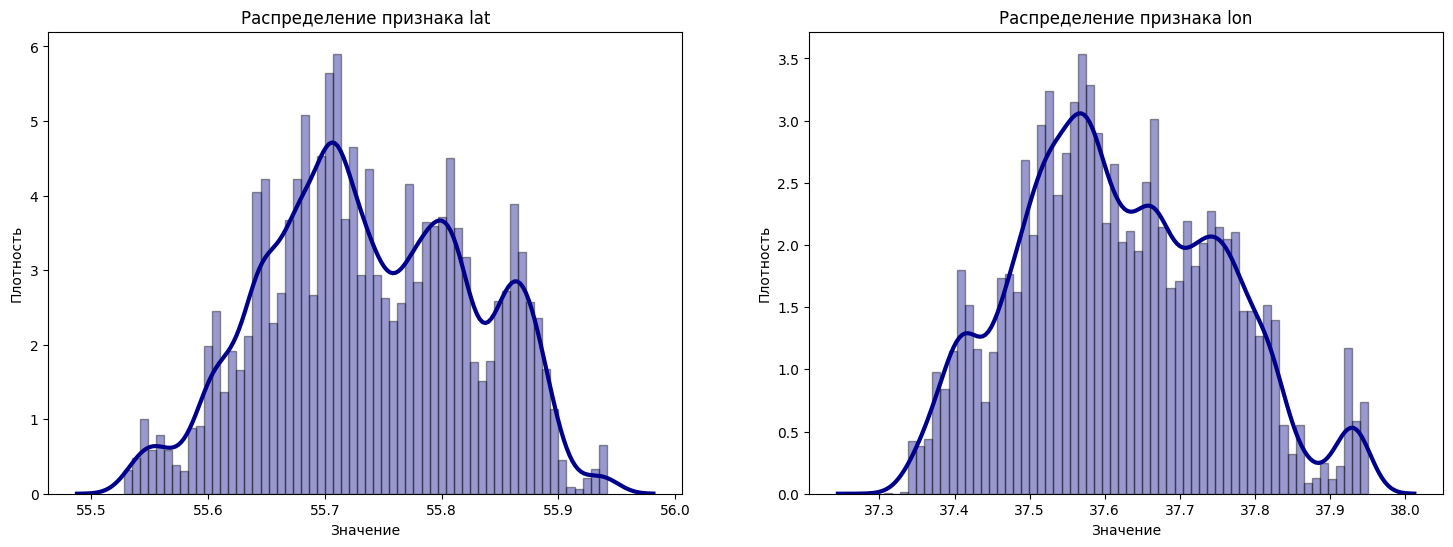

In [25]:
fig, axes = plt.subplots(1, 2)
fig.set_figheight(6)
fig.set_figwidth(18)
sns.distplot(data['lat'], hist=True, kde=True, 
             bins=60, color='darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3}, ax=axes[0])
axes[0].set(xlabel="Значение", ylabel="Плотность", title="Распределение признака lat")

sns.distplot(data['lon'], hist=True, kde=True, 
             bins=60, color='darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3}, ax=axes[1])
axes[1].set(xlabel="Значение", ylabel="Плотность", title="Распределение признака lon")

plt.show()

Зная широту и долготу места расположения квартиры, а также найдя координаты центра города, можно вычислить расстояние от квартиры до центра.\
В качестве центра Москвы возьмем Московский Кремль. Его кооординаты в десятичных градусах: `55.751694°` широты и   `37.617218°` долготы.\
Расстояние от квартир до центра будем находить с помощью функции `distance` модуля `geopy`, вычисляющей геодезическое расстояние между точками. 

In [26]:
from geopy import distance

def get_distance(row):
    flat_coord = (row.lat, row.lon)
    center_coords = (55.751694, 37.617218) # Координаты центра Москвы
    return distance.distance(flat_coord, center_coords).m

In [27]:
# Добавим столбец dist_to_center, обозначающий расстояние от квартиры до центра в метрах
data['dist_to_center'] = data.apply(get_distance, axis = 1)

Также, зная широту и долготу, можно найти азимут - угол между направлениями на север и на место расположения квартиры. Для его нахождения напищем функцию:

In [28]:
def find_azimuth(row):
    
    flat_coord = np.radians(np.array([row.lat, row.lon]))
    center_coords = np.radians(np.array([55.751694, 37.617218])) # Координаты центра Москвы
    
    azimuth = np.arctan2(
        np.sin(center_coords[1] - flat_coord[1]) * np.cos(center_coords[0]),
        np.cos(flat_coord[0]) * np.sin(center_coords[0]) - np.sin(flat_coord[0]) * np.cos(center_coords[0]) * np.cos(center_coords[1] - flat_coord[1])
          )
    azimuth = (np.degrees(azimuth) + 360) % 360 # Масштабирование значения в диапазоне (0, 360)
    return azimuth

In [29]:
# Добавим столбец azimuth, обозначающий угол азимута между центром и квартирой
data['azimuth'] = data.apply(find_azimuth, axis = 1)

Посмотрим на распределение получившихся признаков:

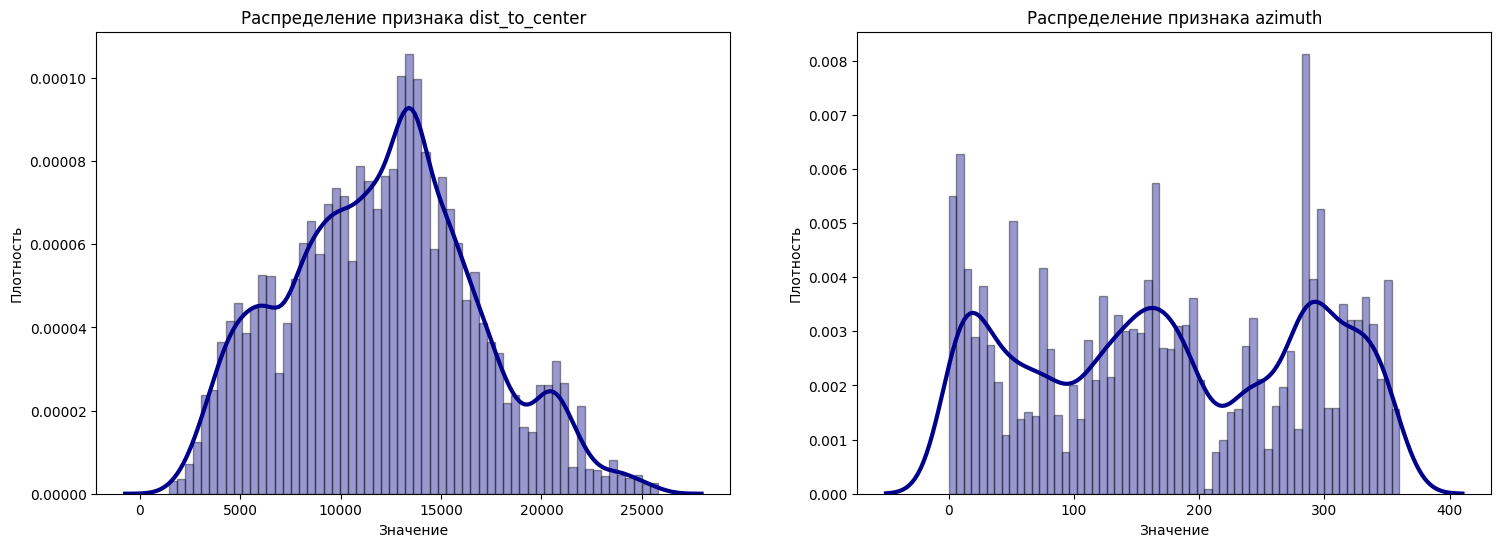

In [30]:
fig, axes = plt.subplots(1, 2)
fig.set_figheight(6)
fig.set_figwidth(18)
sns.distplot(data['dist_to_center'], hist=True, kde=True, 
             bins=60, color='darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3}, ax=axes[0])
axes[0].set(xlabel="Значение", ylabel="Плотность", title="Распределение признака dist_to_center")

sns.distplot(data['azimuth'], hist=True, kde=True, 
             bins=60, color='darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3}, ax=axes[1])
axes[1].set(xlabel="Значение", ylabel="Плотность", title="Распределение признака azimuth")

plt.show()

Так как признак `dist_to_center` говорит практически о том же самом, о чем говорит признак `subway_dist_to_center`, во избежаение проблем с обучением и низким качеством моделей нужно удалить один из признаков.\
Критерием для удаления будет коэффициент корреляции с объясняемой переменной - `price`. Переменную с более высоким коэффициентом корряляции нужно оставить, а другую удалить.\
Рассчитаем коэффиценты корреляции признаков:

In [31]:
# Матрица парной корреляции признаков price и dist_to_center
data[['price', 'dist_to_center', 'subway_dist_to_center']].corr()

,price,dist_to_center,subway_dist_to_center
price,1.000000,-0.369274,-0.366405
dist_to_center,-0.369274,1.000000,0.989159
subway_dist_to_center,-0.366405,0.989159,1.000000


Признак `dist_to_center` имеет более сильную связь с целевой переменной, поэтому удаляем признак `subway_dist_to_center`:

In [32]:
data.drop(["subway_dist_to_center"], axis=1, inplace=True)

Добавим признак `dist_ratio`, рассчитанный как отношении расстояния до ближайшей станции метро к расстоянию до центра города.

In [33]:
data['dist_ratio'] = data['dist_to_subway'] / data['dist_to_center']

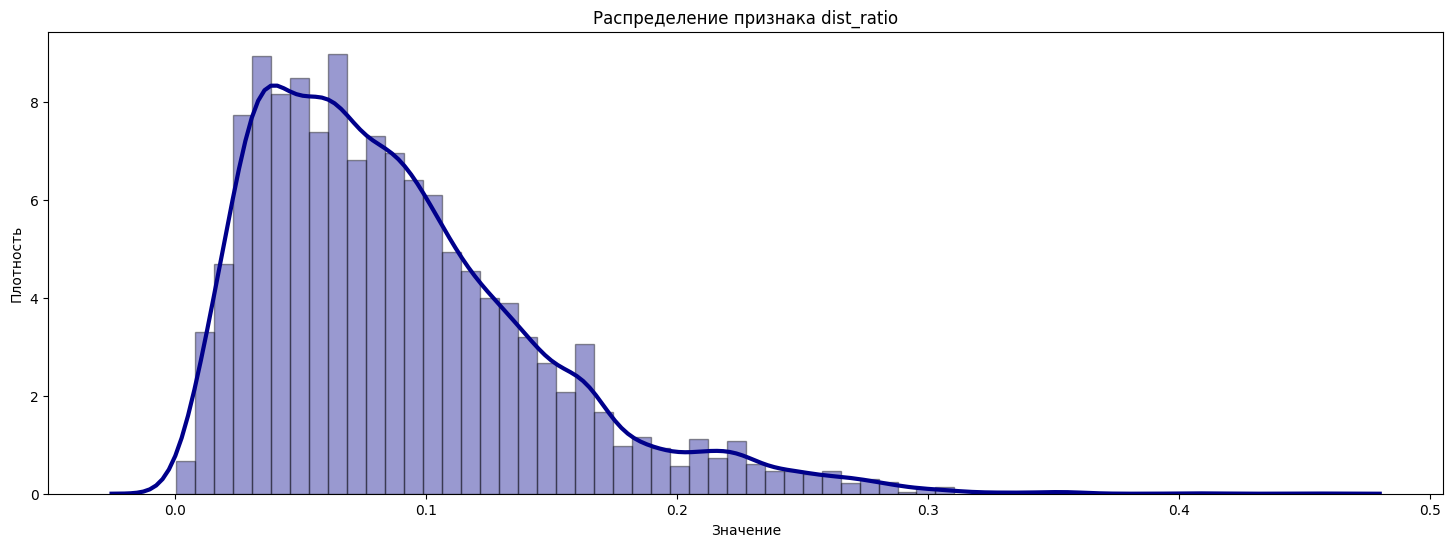

In [34]:
plt.figure(figsize=(18, 6))
ax = sns.distplot(data['dist_ratio'], hist=True, kde=True, 
             bins=60, color='darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})
ax.set(xlabel="Значение", ylabel="Плотность", title="Распределение признака dist_ratio")
plt.show()

#### 6.

Признак `footage` показывает площадь квартиры в квадратных метрах.

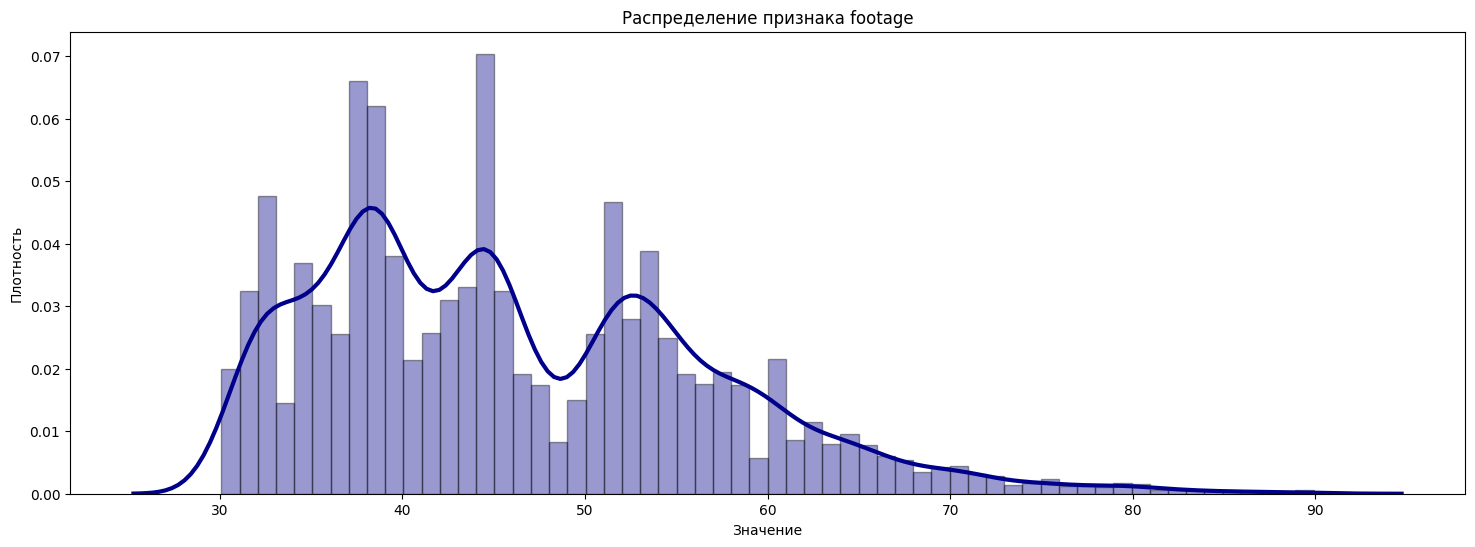

In [35]:
plt.figure(figsize=(18, 6))
ax = sns.distplot(data['footage'], hist=True, kde=True, 
             bins=60, color='darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})
ax.set(xlabel="Значение", ylabel="Плотность", title="Распределение признака footage")
plt.show()

Добавим признаки, связанные с площадью квартиры:
1. `footage_per_room` -  отношение площади к кол-ву комнат.
2. `footage_per_dist_to_center` - отношение площади к расстоянию до центра города.
3. `footage_per_max_floor` - отношение площади к кол-ву этажей в доме.
4. `footage_per_repair` - отношение площади к состоянию квартиры.

In [36]:
data['footage_per_room'] = data['footage'] / data['rooms']
data['footage_per_dist_to_center'] = data['footage'] / data['dist_to_center']
data['footage_per_max_floor'] = data['footage'] / data['max_floor']
data['footage_per_repair'] = data['footage'] / data['repair']

Визуализируем их распределение:

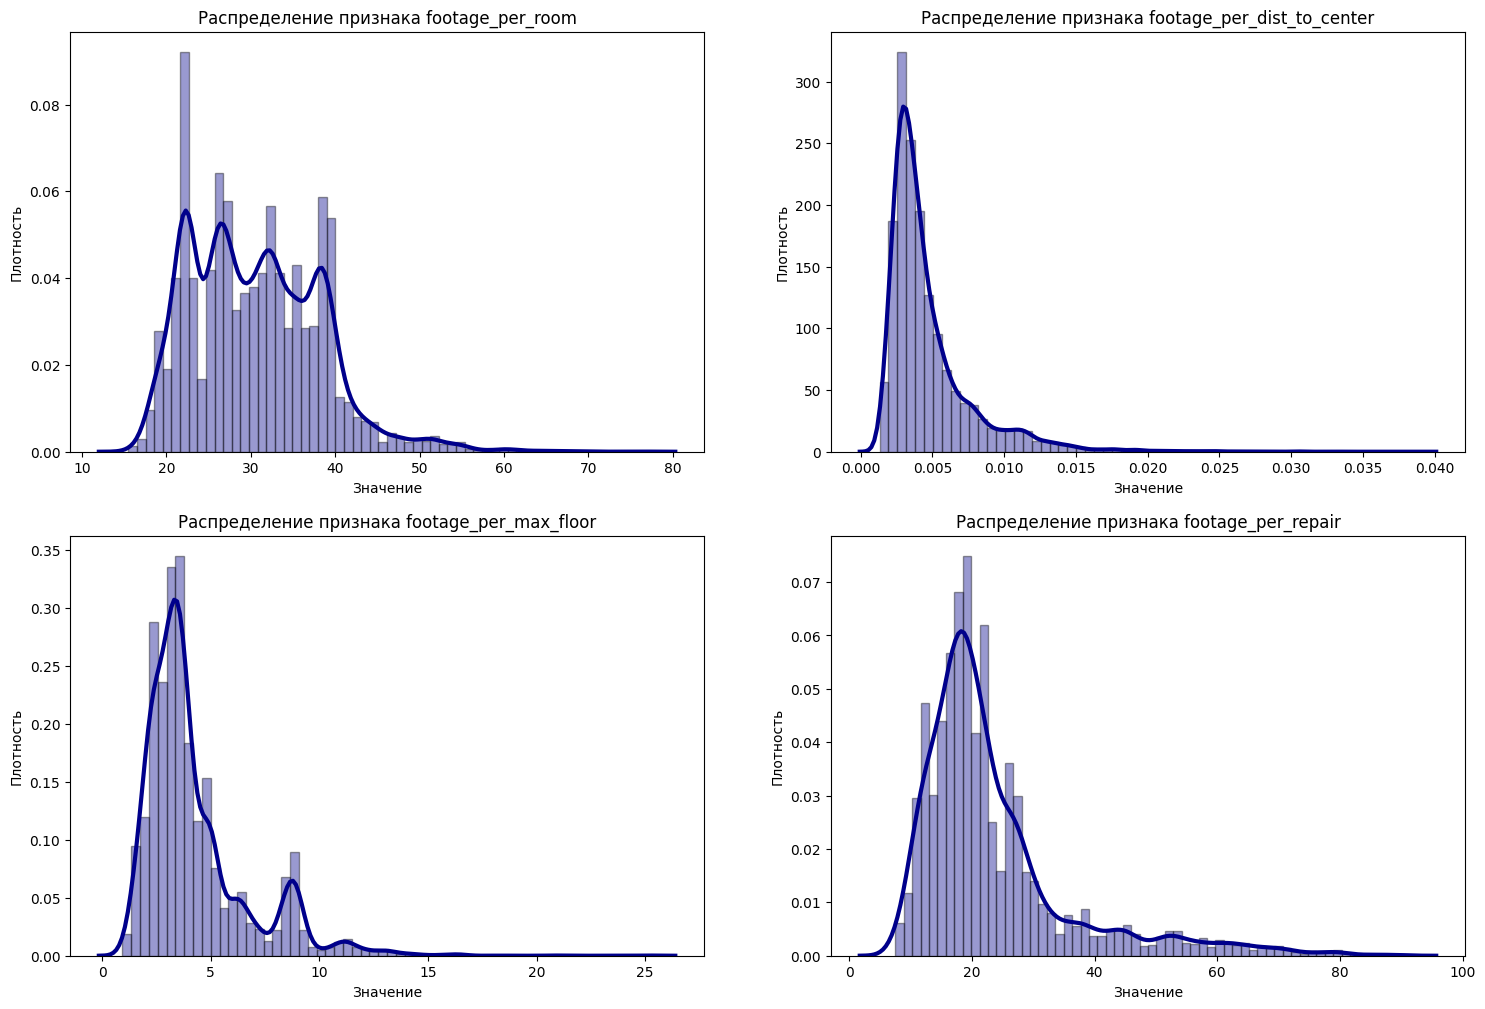

In [37]:
fig, axes = plt.subplots(2, 2)
fig.set_figheight(12)
fig.set_figwidth(18)

sns.distplot(data['footage_per_room'], hist=True, kde=True, 
             bins=60, color='darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3}, ax=axes[0, 0])
axes[0, 0].set(xlabel="Значение", ylabel="Плотность", title="Распределение признака footage_per_room")

sns.distplot(data['footage_per_dist_to_center'], hist=True, kde=True, 
             bins=60, color='darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3}, ax=axes[0, 1])
axes[0, 1].set(xlabel="Значение", ylabel="Плотность", title="Распределение признака footage_per_dist_to_center")

sns.distplot(data['footage_per_max_floor'], hist=True, kde=True, 
             bins=60, color='darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3}, ax=axes[1, 0])
axes[1, 0].set(xlabel="Значение", ylabel="Плотность", title="Распределение признака footage_per_max_floor")

sns.distplot(data['footage_per_repair'], hist=True, kde=True, 
             bins=60, color='darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3}, ax=axes[1, 1])
axes[1, 1].set(xlabel="Значение", ylabel="Плотность", title="Распределение признака footage_per_repair")

plt.show()

Параметр `hm` показывает, из какого материала сделаны стены дома:

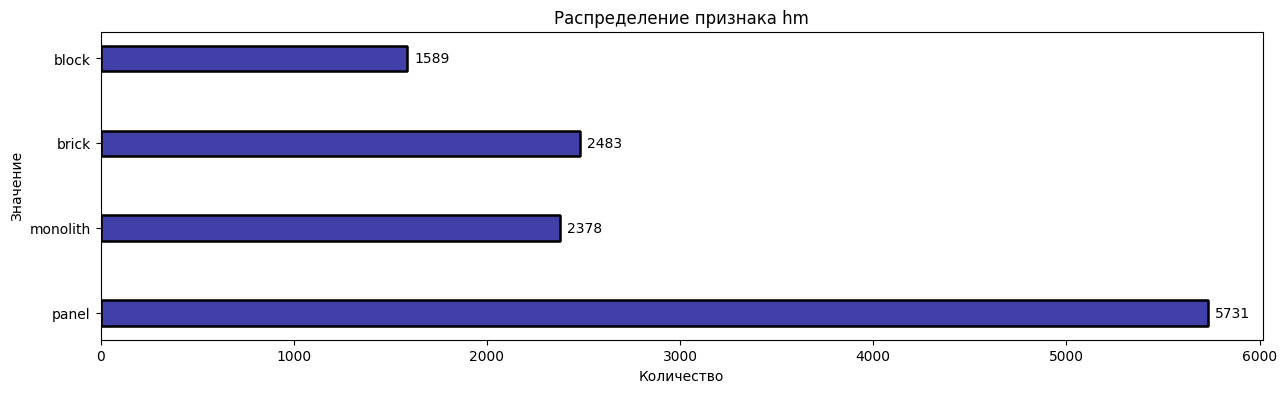

In [38]:
plt.figure(figsize=(15,4))
ax = sns.histplot(data=data, y="hm", bins=9, shrink=0.3, discrete=True, color='darkblue')
ax.set_yticks(np.unique(data[["hm"]]))
ax.set(xlabel="Количество", ylabel="Значение", title="Распределение признака hm")
ax.bar_label(ax.containers[0], fmt='%.0f', padding=5)
plt.show()

Оставшиеся признаки связаны с количеством объявлений: `agent_offers`, `subway_offers` и `address_offers`.\
Узнать, какое влияние они оказывают на формирование цены, можно будет после первичного применения моделей.\
Визуализируем их распределения:

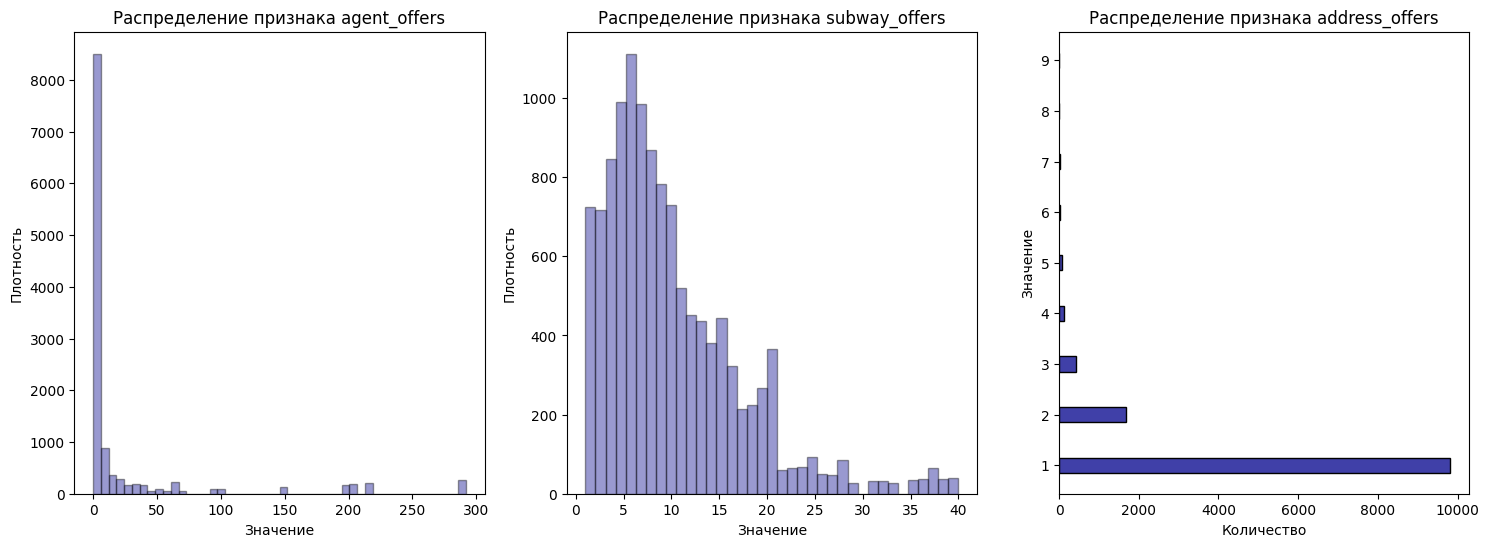

In [39]:
fig, axes = plt.subplots(1, 3)
fig.set_figheight(6)
fig.set_figwidth(18)

sns.distplot(data['agent_offers'], hist=True, kde=False, 
             bins=len(np.unique(data['agent_offers'])), color='darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3}, ax=axes[0])
axes[0].set(xlabel="Значение", ylabel="Плотность", title="Распределение признака agent_offers")

sns.distplot(data['subway_offers'], hist=True, kde=False, 
             bins=len(np.unique(data['subway_offers'])), color='darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3}, ax=axes[1])
axes[1].set(xlabel="Значение", ylabel="Плотность", title="Распределение признака subway_offers")

sns.histplot(data=data, y="address_offers", bins=9, shrink=0.3, discrete=True, color='darkblue', ax=axes[2])
axes[2].set_yticks(range(1, 10))
axes[2].set(xlabel="Количество", ylabel="Значение", title="Распределение признака address_offers")

plt.show()

### Работа с категориальными признаками:

Перед разделением датасета на выборки и применением моделей нужно закодировать категориальные признаки: `closest_subway`, `AO` и `hm`.

Начнем с признака `closest_subway`. Этот признак передает информацию о ближайшей станции метро в виде её идентификатора. Посмотрим на кол-во уникальных значений ID станций:

In [40]:
print(f'Количество уникальных значений признака closest_subway: {len(np.unique(data[["closest_subway"]]))}')

Количество уникальных значений признака closest_subway: 200


Оставить значения признака так, как есть, неправильно, так как его значения не порядковые и не имеют иерархии.
Очевидно, что унитарное кодирование (`one-hot-encoding`) также не подойдет, так как такой подход значительно увеличит кол-во признаков в датасете.\
Одним из способов закодировать такой признак является частотное кодирование (`FrequencyEncoding`). Этот метод сопоставляет каждому признаку частоту его появления в датасете.

Закодируем признак `closest_subway` методом частотного кодирования:

In [41]:
# Получаем частоты признаков:
enc_closest_subway = (data.groupby('closest_subway').size()) / len(data)
enc_closest_subway

closest_subway
0      0.004023
1      0.002791
2      0.008292
3      0.007553
4      0.006814
         ...   
195    0.017568
196    0.003038
197    0.004844
198    0.005172
199    0.006157
Length: 200, dtype: float64

In [42]:
# Добавляем закодированный признак в датасет:
data['closest_subway_encode'] = data['closest_subway'].apply(lambda x : enc_closest_subway[x])

In [43]:
# Удалим оригинальный категориальный признак:
data.drop(["closest_subway"], axis=1, inplace=True)

Далее преобразуем признак `AO`, показывающий принадлежность квартирц какому-либо административному округу.

In [44]:
print(f'Количество уникальных значений признака AO: {len(np.unique(data[["AO"]]))}')

Количество уникальных значений признака AO: 9


Закодируем признак `AO` аналгично предыдущему признаку методом частотного кодирования:

In [45]:
# Получаем частоты признаков:
enc_AO = (data.groupby('AO').size()) / len(data)
enc_AO

AO
CAO     0.053608
SAO     0.116739
SVAO    0.113948
SZAO    0.062392
UAO     0.122814
UVAO    0.168541
UZAO    0.119284
VAO     0.111813
ZAO     0.130860
dtype: float64

In [46]:
# Добавляем закодированный признак в датасет:
data['AO_encode'] = data['AO'].apply(lambda x : enc_AO[x])

In [47]:
# Удалим оригинальный категориальный признак:
data.drop(["AO"], axis=1, inplace=True)

Признак `hm` показывает, из какого материала сделаны стены дома

In [48]:
print(f'Количество уникальных значений признака hm: {len(np.unique(data[["hm"]]))}')

Количество уникальных значений признака hm: 4


Так как признак `hm` принимает всего 4 различных значения, закодируем его методом унитарного кодирования:

In [49]:
data = pd.get_dummies(data=data, columns=['hm'])

Рассмотрим описательную статистику датасета после всех проведенных процедур:

In [50]:
data.describe()

,price,repair,house_age,dist_to_subway,sg,lat,lon,agent_offers,subway_offers,address_offers,...,dist_ratio,footage_per_room,footage_per_dist_to_center,footage_per_max_floor,footage_per_repair,closest_subway_encode,hm_block,hm_brick,hm_monolith,hm_panel
count,1.218100e+04,12181.000000,12181.000000,12181.000000,12181.000000,12181.000000,12181.000000,12181.000000,12181.000000,12181.000000,...,12181.000000,12181.000000,12181.000000,12181.000000,12181.000000,12181.000000,12181.000000,12181.000000,12181.000000,12181.000000
mean,1.086987e+07,2.267302,36.360644,928.353748,0.242673,55.738639,37.618241,25.429932,10.176915,1.290124,...,0.088178,30.534636,0.004716,4.266709,23.636889,0.008174,0.130449,0.203842,0.195222,0.470487
std,3.037320e+06,0.787196,21.406406,532.443508,0.629897,0.087598,0.134112,61.837916,7.078888,0.730561,...,0.056311,7.644555,0.003011,2.381779,12.663580,0.005578,0.336811,0.402869,0.396388,0.499149
min,4.900000e+06,1.000000,0.000000,11.000000,0.000000,55.527631,37.306055,0.000000,1.000000,1.000000,...,0.000567,15.500000,0.001309,0.940541,7.525000,0.000082,0.000000,0.000000,0.000000,0.000000
25%,8.500000e+06,2.000000,17.000000,548.000000,0.000000,55.674840,37.520435,1.000000,5.000000,1.000000,...,0.045336,24.150000,0.002857,2.735294,16.000000,0.004351,0.000000,0.000000,0.000000,0.000000
50%,1.020000e+07,2.000000,42.000000,820.000000,0.000000,55.730855,37.604411,1.000000,8.000000,1.000000,...,0.077279,30.000000,0.003751,3.566667,19.666667,0.006568,0.000000,0.000000,0.000000,0.000000
75%,1.270000e+07,3.000000,54.000000,1177.000000,0.000000,55.806115,37.720789,11.000000,13.000000,1.000000,...,0.117119,36.000000,0.005428,4.977778,26.500000,0.010262,0.000000,0.000000,0.000000,1.000000
max,2.000000e+07,4.000000,130.000000,2988.000000,3.000000,55.941577,37.950668,292.000000,40.000000,9.000000,...,0.454188,76.800000,0.038725,25.300000,89.900000,0.028980,1.000000,1.000000,1.000000,1.000000


In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12181 entries, 0 to 12180
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   price                       12181 non-null  int64   
 1   repair                      12181 non-null  int64   
 2   house_age                   12181 non-null  int64   
 3   dist_to_subway              12181 non-null  int64   
 4   sg                          12181 non-null  float64 
 5   lat                         12181 non-null  float64 
 6   lon                         12181 non-null  float64 
 7   agent_offers                12181 non-null  int64   
 8   subway_offers               12181 non-null  int64   
 9   address_offers              12181 non-null  float64 
 10  rooms                       12181 non-null  int64   
 11  footage                     12181 non-null  float64 
 12  floor                       12181 non-null  int64   
 13  max_floor       

## Разделение данных

Выделим целевую переменную из данных:

In [52]:
y = data.price
y.head()

0     8000000
1     7200000
2    10300000
3     8500000
4     9000000
Name: price, dtype: int64

Отделим целевую переменную от признаков:

In [53]:
X = data.drop(["price"], axis=1)
X.head()

,repair,house_age,dist_to_subway,sg,lat,lon,agent_offers,subway_offers,address_offers,rooms,...,footage_per_room,footage_per_dist_to_center,footage_per_max_floor,footage_per_repair,closest_subway_encode,AO_encode,hm_block,hm_brick,hm_monolith,hm_panel
0,3,42,960,0.0,55.609009,37.734632,1,5,1.0,1,...,39.40,0.002249,3.283333,13.133333,0.007306,0.122814,0,0,0,1
1,2,43,802,0.0,55.608760,37.741936,1,9,1.0,1,...,35.60,0.002006,3.955556,17.800000,0.007306,0.122814,0,0,0,1
2,2,43,638,0.0,55.610207,37.742495,57,9,2.0,2,...,26.50,0.003009,4.416667,26.500000,0.007306,0.122814,0,0,0,1
3,2,43,929,0.0,55.624017,37.740373,292,5,1.0,2,...,22.05,0.002724,4.900000,22.050000,0.007306,0.122814,0,0,0,1
4,2,43,785,0.0,55.609107,37.740430,292,5,1.0,2,...,22.10,0.002502,4.911111,22.100000,0.007306,0.122814,0,0,0,1


Далее нужно удалить выбросы в данных. В качестве модели детекции выбросов возьмем `LocalOutlierFactor`, которая использует меру выброса как расстояние до k-го соседа. Принцип работы этого алгоритма основан на допущении, что данные, являющиеся выбросами, отдалены от своих соседей, а нормальные, "однородные" данные обычно сгруппированы вместе.

In [54]:
from sklearn.neighbors import LocalOutlierFactor

orig_shape = X.shape

outlier_markers = LocalOutlierFactor(n_neighbors=5).fit_predict(X)
X = X.loc[outlier_markers == 1]
y = y.loc[X.index]
preproc_shape = X.shape

print(f'Размер выборки до удаления выбросов: {orig_shape}')
print(f'Размер выборки после удаления выбросов: {preproc_shape}')
print(f'Выборка уменьшилась на {(orig_shape[0]-preproc_shape[0])/orig_shape[0]*100}%\
      ({orig_shape[0]-preproc_shape[0]} эл.)')

Размер выборки до удаления выбросов: (12181, 29)
Размер выборки после удаления выбросов: (10705, 29)
Выборка уменьшилась на 12.117231754371561%      (1476 эл.)


Разделим датасет на обучающую, валидационну и тестовую выборки:
* **Обучающая выборка** нужна для обучения моделей (`80%` датасета).
* На **валидационной выборке** будет проходить первичное оценивание эффективности моделей и подбор гиперпараметров (`15%` датасета).
* На **тестовой выборке** будет проходить финальное оценивание эффективности модели (`5%` датасета).

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_val_test, y_train, y_val_test = train_test_split(
    X, y, 
    test_size=0.1999, 
    random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, 
    test_size=0.25, 
    random_state=42)

all_samples_X = [X_train, X_val, X_test]

Выведем размеры выборок:

In [56]:
samples = ['Обучающая', 'Валидационная', 'Тестовая']
samples_size_el = np.array([s.shape[0] for s in (X_train, X_val, X_test)])
samples_size_perc = samples_size_el / X.shape[0] * 100

samples_info = pd.DataFrame({'Выборка': samples, 'Размер, элементов': samples_size_el, 'Размер, %': samples_size_perc})
samples_info

,Выборка,"Размер, элементов","Размер, %"
0,Обучающая,8565,80.009341
1,Валидационная,1605,14.992994
2,Тестовая,535,4.997665


## Выбор метрик

Метрикой сравнения эффективностей различных моделей будет выступать скорректированный коэффицент детерминации:
$$R_{adj}^2 = 1 - (1 - R^2)\frac{n-1}{n-k}$$
где $R^2$ - коэффицент детерминации, $n$ - кол-во наблюдений, $k$ - кол-во объясняющих переменных.\
Причиной выбора этой метрики для сравнения моделей стало то, что при использовании обычного, нескорректированного $R^2$ значение коэффицента возрастает при увеличении чиса объясняющих переменных. Скорректированный коэффициент детерминации позволяет решить данную проблему, поскольку вводит штраф модели, который увеличивается при добавлении каждой переменной.

In [57]:
from sklearn.metrics import r2_score

def r2_adj(y, y_pred, k=1):
    return 1 - (1 - r2_score(y, y_pred)) * (y.shape[0] - 1) / (y.shape[0] - k)

Для интерпретации качества пресказаний цены будем использовать метрику $MAPE$: $$MAPE = \frac{100\%}{n} \cdot |\sum \frac{y_i - \hat{y_i}}{y_i}|$$
Её значение покажет средний процент ошибки в предсказании.

In [58]:
from sklearn.metrics import mean_absolute_percentage_error

Еще одним показателем прменяемых моделей является время их обучения. Для замера времени импортируем модуль `time`:

In [59]:
import time

Для визуализации эффективности моделей будем выводить таблицу с основными характеристиками: значениями метрик и временем обучения.\
Для создания таких таблиц напишем функцию:

In [60]:
def metrics_table(y, y_pred, X, fit_time):
    r2_adj_score = r2_adj(y, y_pred, X.shape[1])
    mae_score = mean_absolute_percentage_error(y, y_pred)
 
    metrics_df = pd.DataFrame({
        'Метрика': ['Cкорректированный коэф. детерминации', 'Средняя абсолютная процентная ошибка', 'Время обучения'],
                               'Значение': [r2_adj_score, mae_score, fit_time]})
    metrics_df = metrics_df.style.format({'Значение': '{:.5f}'})
    return metrics_df

Для удобства замера времени "обернем" функцию обучения `fit` в другую функцию:

In [61]:
def fit_with_time(estimator, X_train, y_train):
    start = time.time()
    estimator.fit(X_train, y_train)
    fit_time = time.time() - start
    return fit_time

## Обучение моделей

Так как данные в нашей задаче являются табличными и неоднородными: каждый признак имеет свое распределение, масштаб и силу влияния на целевую переменную, оптимальными классами алгоритмов будут модели, использующие деревья решений. Такие модели способны эффективно находить нелинейные зависимости в данных с признаками различной природы.

В качестве моделей в данной работе будут использоваться деревья решений `DecisionTreeRegressor` и различные ансамбли алгоритмов на их основе: случайный лес `RandomForestRegressor`, дополнительные деревья `ExtraTreesRegressor` и градиентный бустинг `GradientBoostingRegressor`.

Очевидно, что не все из признаков, которые сейчас присутствуют в выборках, помогают предсказать цену. Оценить их влияние можно с помощью метода `feature_importances_`.

In [62]:
# В переменную results будут сохраняться датафреймы, содержащие информацию об эффективности моделей
results = []

In [63]:
# В переменную feature_importance будут сохраняться массивы, содержащие информацию о важности признаков
feature_importance = []
f_names = X.columns

### 1. Дерево решений (***DecisionTreeRegressor***)

In [64]:
from sklearn.tree import DecisionTreeRegressor

DTr = DecisionTreeRegressor()

fit_time = fit_with_time(DTr, X_train, y_train)

y_pred_DTr = DTr.predict(X_val)
DTr_results = metrics_table(y_val, y_pred_DTr, X_val, fit_time)
DTr_f_i = DTr.feature_importances_
results.append(DTr_results)
feature_importance.append(DTr_f_i)

DTr_results

,Метрика,Значение
0,Cкорректированный коэф. детерминации,0.76294
1,Средняя абсолютная процентная ошибка,0.08770
2,Время обучения,0.11594


### 2. Случайный лес (***RandomForestRegressor***)

In [65]:
from sklearn.ensemble import RandomForestRegressor

RFr = RandomForestRegressor()

fit_time = fit_with_time(RFr, X_train, y_train)

y_pred_RFr = RFr.predict(X_val)
RFr_results = metrics_table(y_val, y_pred_RFr, X_val, fit_time)
RFr_f_i = RFr.feature_importances_
results.append(RFr_results)
feature_importance.append(RFr_f_i)

RFr_results

,Метрика,Значение
0,Cкорректированный коэф. детерминации,0.89017
1,Средняя абсолютная процентная ошибка,0.06317
2,Время обучения,10.84853


### 3. Дополнительные деревья (***ExtraTreesRegressor***)

In [66]:
from sklearn.ensemble import ExtraTreesRegressor

ETr = ExtraTreesRegressor()

fit_time = fit_with_time(ETr, X_train, y_train)

y_pred_ETr = ETr.predict(X_val)
ETr_results = metrics_table(y_val, y_pred_ETr, X_val, fit_time)
ETr_f_i = ETr.feature_importances_
results.append(ETr_results)
feature_importance.append(ETr_f_i)

ETr_results

,Метрика,Значение
0,Cкорректированный коэф. детерминации,0.89534
1,Средняя абсолютная процентная ошибка,0.06005
2,Время обучения,3.84802


### 4. Градиентный бустинг (***GradientBoostingRegressor***)

In [67]:
from sklearn.ensemble import GradientBoostingRegressor

GBr = GradientBoostingRegressor()

fit_time = fit_with_time(GBr, X_train, y_train)

y_pred_GBr = GBr.predict(X_val)
GBr_results = metrics_table(y_val, y_pred_GBr, X_val, fit_time)
GBr_f_i = GBr.feature_importances_
results.append(GBr_results)
feature_importance.append(GBr_f_i)

GBr_results

,Метрика,Значение
0,Cкорректированный коэф. детерминации,0.86008
1,Средняя абсолютная процентная ошибка,0.07428
2,Время обучения,3.18214


Соберем данные по всем моделям:

In [68]:
# Cводная таблица со значениями метрик
pivot_metrics_table = pd.concat([df.data for df in results])

from itertools import repeat

pivot_metrics_table['Модель'] = sum(
    [list(repeat(model, 3)) for model in 
     ['Дерево решений', 'Случайный лес', 'Дополнительные деревья', 'Градиентный бустинг']], [])

pivot_metrics_table = pd.pivot_table(pivot_metrics_table,
                                       columns=["Метрика"],
                                       index=['Модель'],
                                       values=['Значение'])
pivot_metrics_table = pivot_metrics_table.style.format({'Значение': '{:.2f}'})
pivot_metrics_table.data.columns = list(map(lambda x: x[1], pivot_metrics_table.data.columns.to_list()))
pivot_metrics_table = pivot_metrics_table.data
pivot_metrics_table

,Cкорректированный коэф. детерминации,Время обучения,Средняя абсолютная процентная ошибка
Модель,,,
Градиентный бустинг,0.860083,3.182144,0.074284
Дерево решений,0.762942,0.115938,0.087700
Дополнительные деревья,0.895345,3.848019,0.060055
Случайный лес,0.890167,10.848528,0.063172


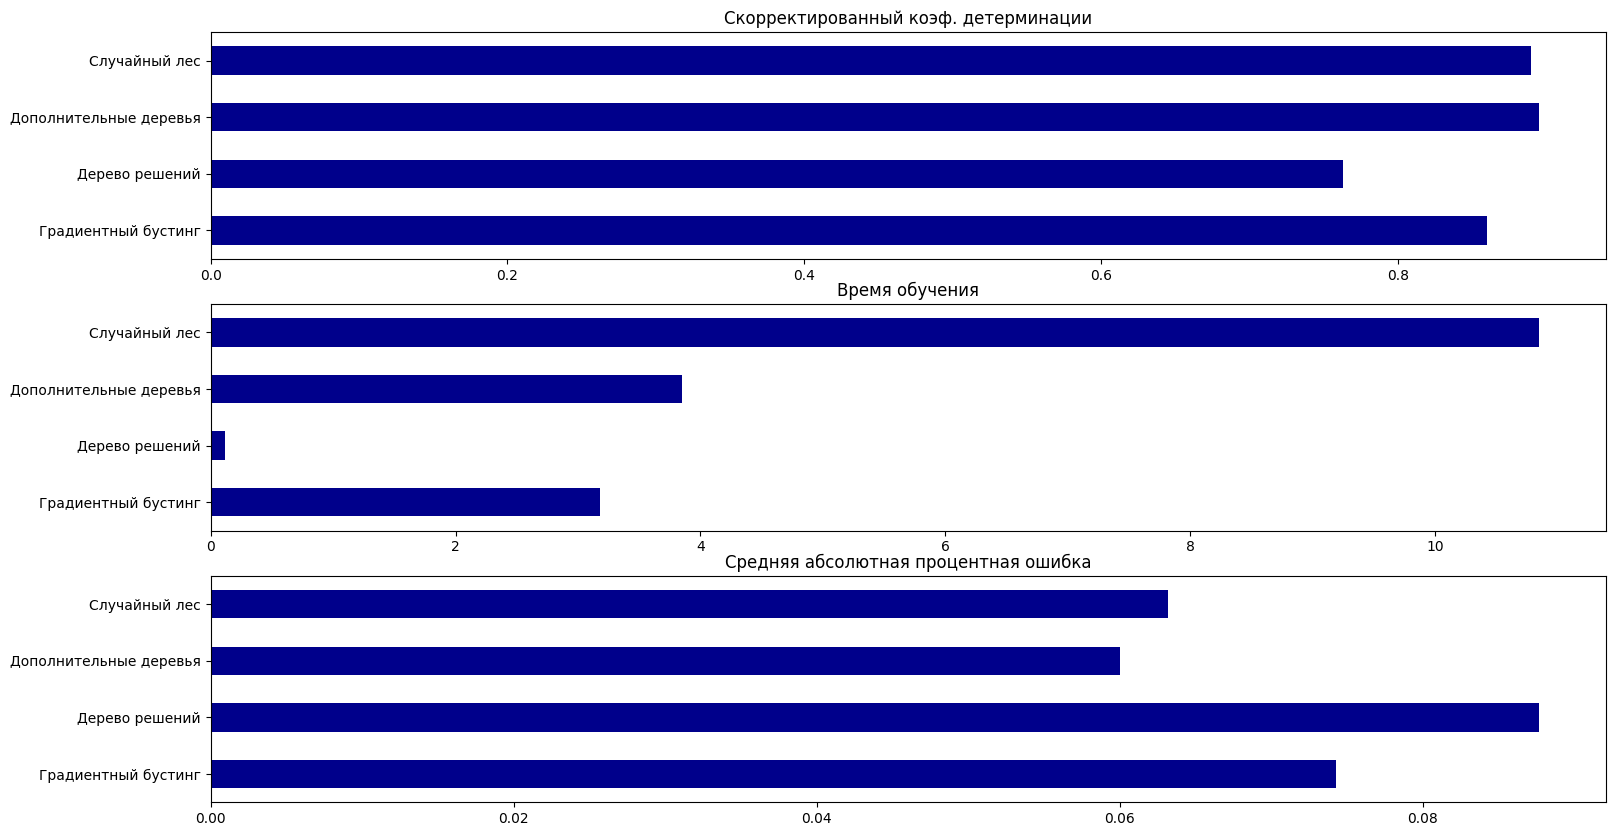

In [69]:
fig, axes = plt.subplots(3, 1)
fig.set_figheight(10)
fig.set_figwidth(18)

pivot_metrics_table['Cкорректированный коэф. детерминации'].plot.barh(ax=axes[0], color='darkblue')
pivot_metrics_table['Время обучения'].plot.barh(ax=axes[1], color='darkblue')
pivot_metrics_table['Средняя абсолютная процентная ошибка'].plot.barh(ax=axes[2], color='darkblue')
axes[0].set(xlabel="", ylabel="", title="Cкорректированный коэф. детерминации")
axes[1].set(xlabel="", ylabel="", title="Время обучения")
axes[2].set(xlabel="", ylabel="", title="Средняя абсолютная процентная ошибка")

plt.show()

По текущим значениям метрик лучшей моделью ялвяется алгоритм дополнительных деревьев.

Построим диаграмму важности признаков с разделением по моделям:

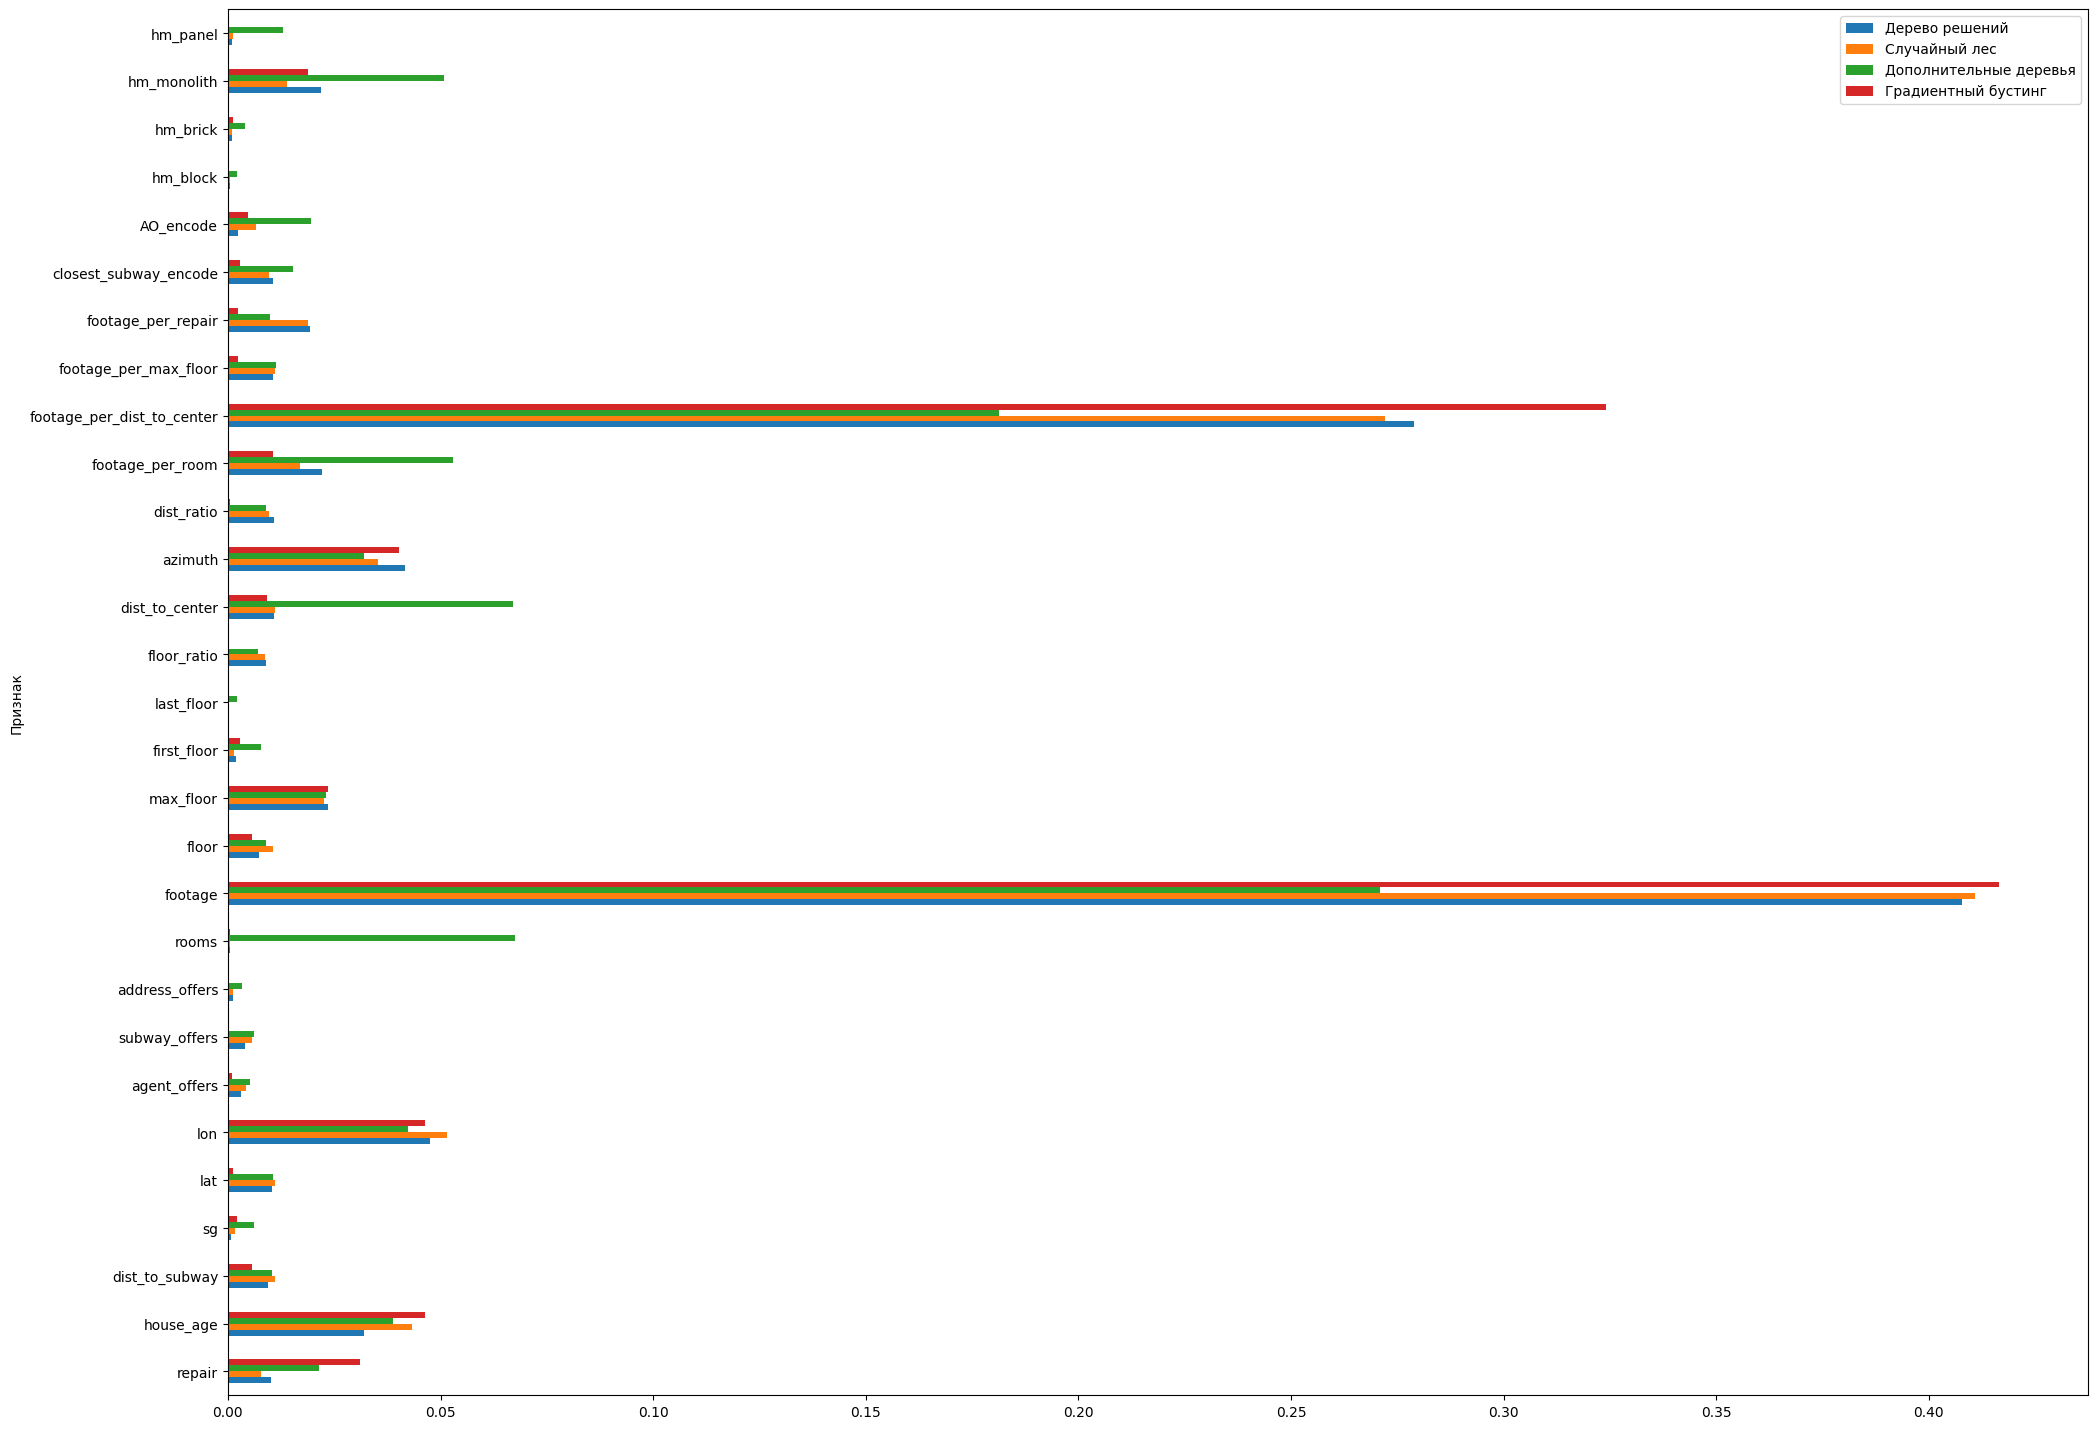

In [70]:
# Столбчатая диаграмма важности признаков
feature_importance_dict = {}
for i, name in enumerate(f_names):
    feature_importance_dict[name] = np.array(feature_importance)[:, i]
df = pd.DataFrame(feature_importance_dict).T
df.columns = ['Дерево решений', 'Случайный лес', 'Дополнительные деревья', 'Градиентный бустинг']
df.plot.barh(figsize=(24, 18), xlabel='Признак', ylabel='Вклад')
plt.show()

По диаграмме видно, что модель дополнительных деревьев высоко оценивает влияние некоторых признаков, которые другие модели считают не важными, например, `rooms`, `dist_to_center`, `footage_per_room`. Это говорит о том, что модель смогла найти разделения в значениях этих признаков, влияющие на цену.

## Подбор гиперпараметров

После выбора модели следует настройка гиперпараметров. Для их настройки будем использовать поиск по сетке с помощью модуля `GridSearchCV`. Предпочтение будет отдаваться параметрам, уменьшающим значение метрики $MAPE$.

In [71]:
from sklearn.model_selection import GridSearchCV

model = ExtraTreesRegressor()

In [72]:
# Список и значения подбираемых параметров
grid = {
    'n_estimators': [100, 1000, 2000],
    'criterion': ['squared_error', 'friedman_mse'],
    'max_depth': [30, 60, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_weight_fraction_leaf': [x / 10 for x in range(0, 3)],
    'max_leaf_nodes': [2, 5, 20, None]}

In [76]:
# Подбор параметров
grid_search = GridSearchCV(ETr, grid, cv=3, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=ExtraTreesRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'friedman_mse'],
                         'max_depth': [30, 60, None],
                         'max_leaf_nodes': [2, 5, 20, None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
                         'n_estimators': [100, 1000, 2000]},
             scoring='neg_mean_absolute_percentage_error')

In [79]:
# Подобранные параметры:
best_params = grid_search.best_params_
best_params

{'criterion': 'friedman_mse',
 'max_depth': 60,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 2000}

## Финальная оценка эффективности

Сравним эффективности модели дополнительных деревьев до и после подбора гиперпараметров. Для оценки качества юудем испольовать выборки `X_test` И `y_test`, данные из которых модели еще не "видели".

In [80]:
def_model = ExtraTreesRegressor()
tun_model = ExtraTreesRegressor(**best_params)

In [81]:
# Модель с гиперпараметрами по умолчанию
fit_time = fit_with_time(def_model, X_train, y_train)

y_pred_def_model = def_model.predict(X_test)
def_model_results = metrics_table(y_test, y_pred_def_model, X_test, fit_time)

def_model_results

,Метрика,Значение
0,Cкорректированный коэф. детерминации,0.88259
1,Средняя абсолютная процентная ошибка,0.06081
2,Время обучения,3.92634


In [82]:
# Модель с подобранными гиперпараметрами
fit_time = fit_with_time(tun_model, X_train, y_train)

y_pred_tun_model = tun_model.predict(X_test)
tun_model_results = metrics_table(y_test, y_pred_tun_model, X_test, fit_time)

tun_model_results

,Метрика,Значение
0,Cкорректированный коэф. детерминации,0.88516
1,Средняя абсолютная процентная ошибка,0.06020
2,Время обучения,78.04519


Визуализируем сравнения метрик двух моделей:

In [83]:
pivot_metrics_table = pd.DataFrame([['По умолчанию'] + np.ravel(def_model_results.data[['Значение']]).tolist(),
['Подобранные по сетке'] + np.ravel(tun_model_results.data[['Значение']]).tolist()], 
columns=['Гиперпараметры модели', 'Cкорректированный коэф. детерминации', 'Средняя абсолютная процентная ошибка', 'Время обучения'])
pivot_metrics_table.set_index('Гиперпараметры модели', inplace=True)
pivot_metrics_table

,Cкорректированный коэф. детерминации,Средняя абсолютная процентная ошибка,Время обучения
Гиперпараметры модели,,,
По умолчанию,0.882590,0.060806,3.926342
Подобранные по сетке,0.885157,0.060205,78.045191


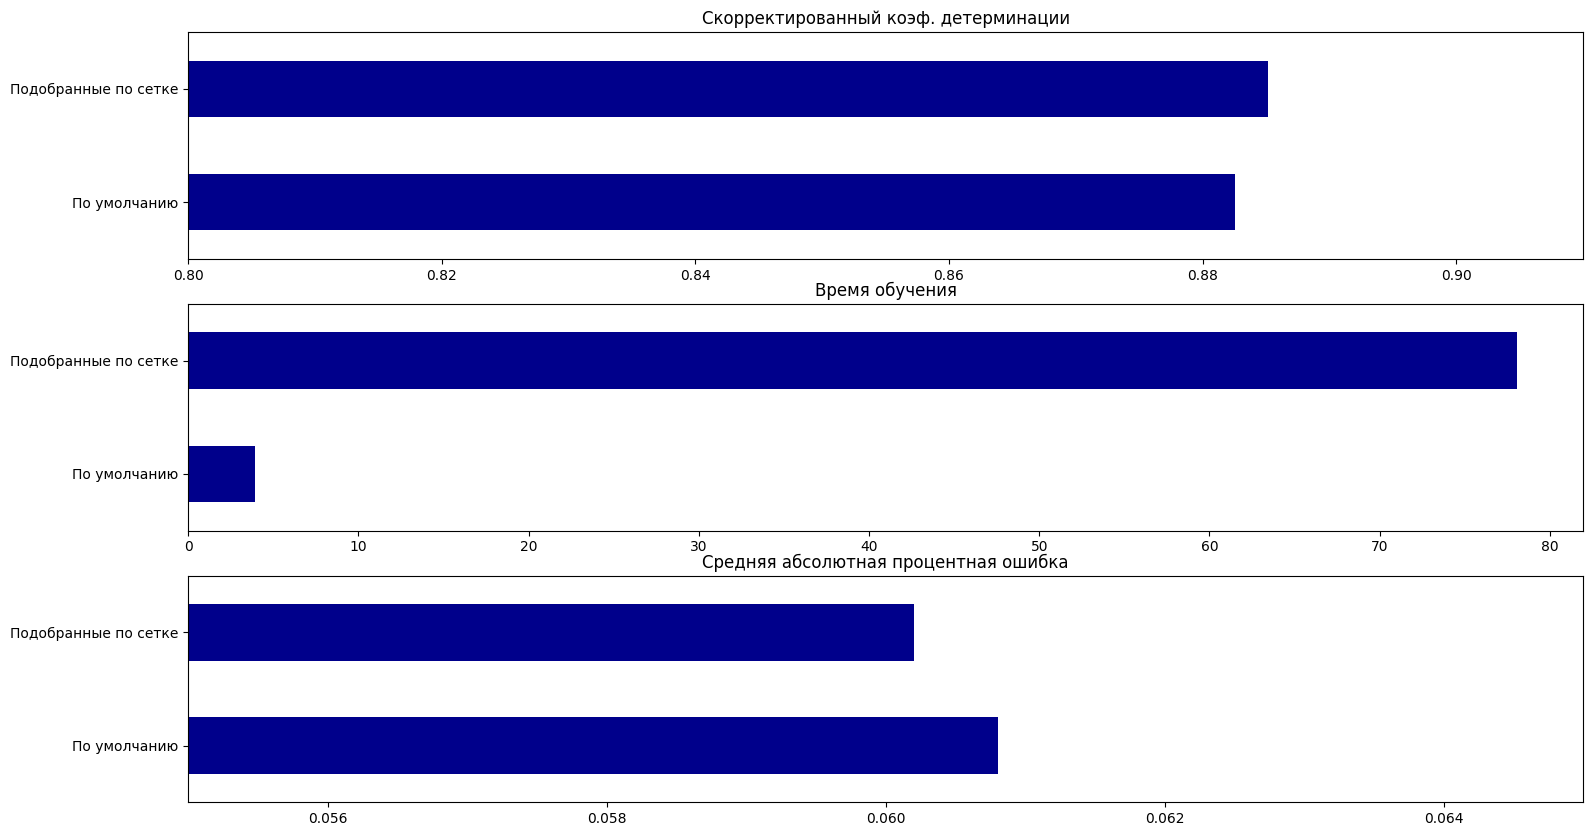

In [85]:
fig, axes = plt.subplots(3, 1)
fig.set_figheight(10)
fig.set_figwidth(18)

pivot_metrics_table['Cкорректированный коэф. детерминации'].plot.barh(ax=axes[0], color='darkblue', xlim=(0.8, 0.91))
pivot_metrics_table['Время обучения'].plot.barh(ax=axes[1], color='darkblue')
pivot_metrics_table['Средняя абсолютная процентная ошибка'].plot.barh(ax=axes[2], color='darkblue', xlim=(0.055, 0.065))
axes[0].set(xlabel="", ylabel="", title="Cкорректированный коэф. детерминации")
axes[1].set(xlabel="", ylabel="", title="Время обучения")
axes[2].set(xlabel="", ylabel="", title="Средняя абсолютная процентная ошибка")

plt.show()

## Выводы

В данной работе было представлено применение методов машинного обучения в задаче ценообразования на рынке недвижимости.\
Была решена задача множественной регрессии.

На первом этапе был произведен анализ признаков на предмет валидности значений, созданы дополнительные признаки.

Далее данные были обработаны: категориальные признаки были закодированы с помощью унитарного и частотного методов кодирования, был применен метод обучения без учителя `LocalOutlierFactor` для детекции и удаления выбросов. Данные были разделены на столбец-целевую переменную и таблицу-признаки, которые в дальнешем разделились на тренировочную, валидационную и тестовую выборки.

В качестве семейства моделей были выбраны деревья решений. Выбор был обусловлен данными: они неодноднородные, имеют разный масштаб, единицы измерения и силу влияния на целевую переменную. Деревья решений анализируют значения признаков и находят их оптимальные разделения. Еще одной оссобенностью этого семества моделей является отбор важных признаков (имеющих влияние на целевую переменную) и отброс неважных (под отбросом понимается ситуация, когда присутствие признака в дереве минимизировано).\
В качестве моделей были выбраны деревья решений и ансамбли на их основе: градиентный бустинг, случайный лес и дополнительные деревья.

После применения моделей и анализа результатов стало понятно, что в нашей задаче наиболее перспективным является алгоритм дополнительных деревьев - он находил более глубокие зависимости между различными признаками и целевой переменной. Для улучшения модели был произведен подбор гиперпараметров с помощью поиска по сетке. После подбора настроенная модель показала лучшую эффективность по сравнению с оригинальной.